In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
import hdbscan
%matplotlib inline
from filter_data import *
from syn_model import *
from load_and_clean import *
from cycler import cycler

import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from scipy.stats import kstest
from sklearn.metrics import mean_squared_error

# calculate the spearmans's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import spearmanr, pearsonr
from math import ceil

# autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm
from matplotlib.collections import PolyCollection, LineCollection
from statsmodels.tsa.stattools import acf, pacf




#IPython.OutputArea.auto_scroll_threshold = 9999;

## Loading data

In [3]:
#update_data()
#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple = load_clean('mobility Apple')
mobility_data_google, google_social = load_clean('mobility Google')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

ctp_us_data = load_clean('CTP US')
ctp_state_data = load_clean('CTP states')
ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

/Users/codymorrin/covid/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)
/Users/codymorrin/covid/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/codymorrin/covid/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns & pop


These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'France-Saint Pierre and Miquelon', 'United Kingdom-British Virgin Islands', 'Australia-Northern Territory', 'China-Shandong', 'Canada-Nunavut', 'China-Shanxi', 'Canada-Grand Princess', 'United Kingdom-Falkland Islands (Malvinas)', 'China-Tibet', 'Canada-Repatriated Travellers', 'China-Inner Mongolia', 'China-Hunan', 'Kyrgyzstan', 'China-Shanghai', 'China-Xinjiang', 'Diamond Princess', 'Australia-Australian Capital Territory', 'Congo (Kinshasa)', 'China-Beijing', 'United Kingdom-Montserrat', 'Canada-Northwest Territories', 'France-Reunion', 'France-French Polynesia', 'United Kingdom-Bermuda', 'Canada-New Brunswick', 'China-Jiangxi', 'France-Martinique', 'Canada-Nova Scotia', 'Australia-Tasmania', 'United Kingdom-Anguilla', 'China-Guizhou', 'China-Henan', 'United Kingdom-Gibraltar', 'Slovakia', 'China-Sichuan', 'MS Zaandam', 'Syria', 'Canada-Manitoba', 'China-Sha

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


last date
Exceptions are []


## Set up possible donors

In [5]:
#collect donors pool which consist the counties in cluster_2_state with long spreading time 
#cluster_2_states = no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii

cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

## Train model with different singular values

In [6]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']

models = []

for singVals in range(1,30):

    target_model = []
    cluster_2_model = []

    #print("Intervention date: ", testDF.index[0])
    for state in targets:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        if state in otherStates:
            otherStates.remove(state)


        rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel.fit_model()
        target_model.append(rscModel)

        predictions = rscModel.predictions
        model_fit = rscModel.model_fit

        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]

        if new_state in otherStates:
            otherStates.remove(new_state)

        rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel2.fit_model()
        cluster_2_model.append(rscModel2)

        predictions = rscModel2.predictions
        model_fit = rscModel2.model_fit
    
    models.append((target_model, cluster_2_model)) #Storing both the model for noreasther state and our target state


In [7]:
models[0][0][0].train.to_csv("testing.csv")

In [8]:
print(len(models), len(models[0]), len(models[0][0]))

29 2 5


## Filter out some counties with high RI

In [9]:
k = 15
fig, axes = plt.subplots(k, 2, figsize = (15, 60))
c = 3 #the cut off when generating new donor pool
p = 1
old = np.empty((k, 2))
new = np.empty((k, 2))

new_model_list = []    
stat_index = 3 #The index of the state we are plotting in the target list
print("Analysis for state %s"%(models[0][0][stat_index].state))

for i in range(k):
    perm_dict = models[i][0][stat_index].permutation_distribution(show_graph = False)
    old[i][1] = perm_dict.pop(models[i][0][stat_index].state)
    
     
    selected = np.array(list(perm_dict.values()))
    old[i][0] = np.mean(selected)
    axes[i][0].hist(selected, bins = 15)
    
    axes[i][0].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(selected), np.std(selected), models[i][0][stat_index].find_ri()))
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]

    new_model = syn_model(models[i][0][stat_index].state,  models[i][0][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_model_list.append(new_model)
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())
    new[i][0] = np.mean(values)

    axes[i][1].hist(values, bins = 8)
    axes[i][1].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(values), np.std(values), new_model.find_ri()))

Analysis for state Bartholomew-Indiana


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/

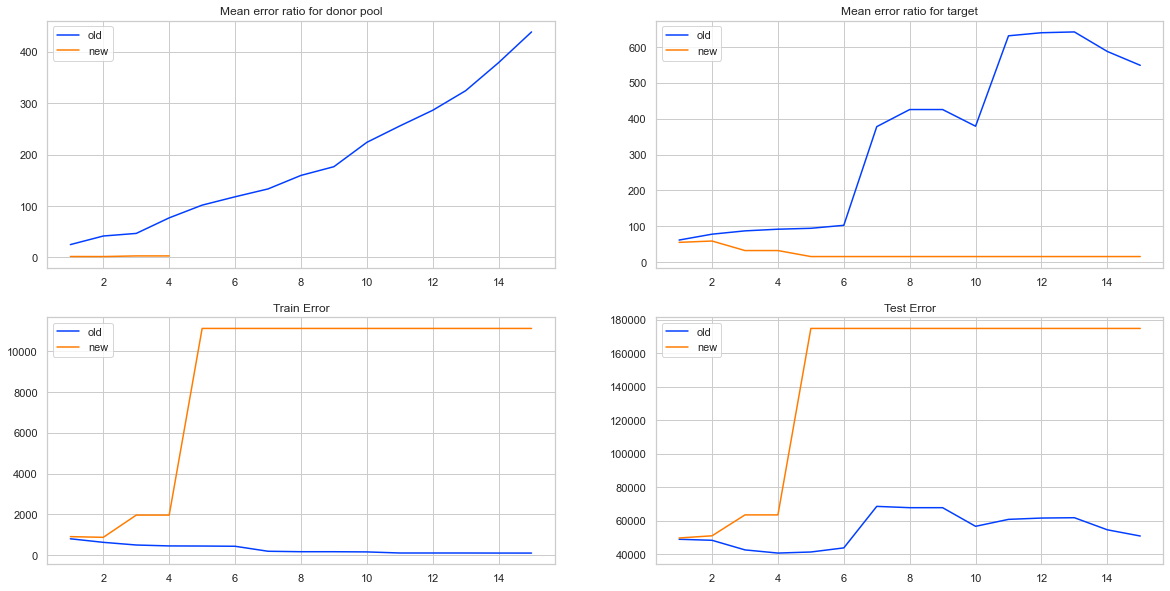

In [10]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))
axes[0][0].plot(range(1, len(old.T[0]) + 1), old.T[0], label = 'old')
axes[0][0].plot(range(1, len(new.T[0]) + 1), new.T[0], label = 'new')
axes[0][0].set_title('Mean error ratio for donor pool')
axes[0][0].legend()

axes[0][1].plot(range(1, len(old.T[1]) + 1), old.T[1], label = 'old')
axes[0][1].plot(range(1, len(new.T[1]) + 1), new.T[1], label = 'new')
axes[0][1].set_title('Mean error ratio for target')
axes[0][1].legend()

old_train_error = [m[0][stat_index].train_err for m in models[:k]]
old_test_error = [m[0][stat_index].test_err for m in models[:k]]

new_train_error = [new_model_list[i].train_err for i in range(k)]
new_test_error = [new_model_list[i].test_err for i in range(k)]

axes[1][0].plot(range(1, len(old.T[0]) + 1), old_train_error, label = 'old')
axes[1][0].plot(range(1, len(new.T[0]) + 1), new_train_error, label = 'new')
axes[1][0].set_title('Train Error')
axes[1][0].legend()


axes[1][1].plot(range(1, len(old.T[1]) + 1), old_test_error, label = 'old')
axes[1][1].plot(range(1, len(new.T[1]) + 1), new_test_error, label = 'new')
axes[1][1].set_title('Test Error')
axes[1][1].legend()


plt.show()

## Singular value threshold in training (difference between denoisedDF and actual)

In [11]:
num_states = len(models[0][0])
for stat_index in range(num_states):
    
    print((models[0][0][stat_index].state))
    X = models[0][0][stat_index].train
    a = np.max(X, axis = 0)
    b = np.min(X, axis = 0)
    X = (X - (a + b)/2)/((b-a)/2)
    mean = np.mean(X, axis = 1)
    p = 1
    sigma = np.sum(np.square(X[models[0][0][stat_index].state] - mean))/(len(X)-1)
    #sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
    s = np.linalg.svd(X)[1]
    l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
    h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

    l = len(s[s > l])
    h = len(s[s > h])
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 
                                                                  # https://www.jmlr.org/papers/volume19/17-777/17-777.pdf
    
    print((models[0][1][stat_index].state))
    X = models[0][1][stat_index].train
    a = np.max(X, axis = 0)
    b = np.min(X, axis = 0)
    X = (X - (a + b)/2)/((b-a)/2)
    mean = np.mean(X, axis = 1)
    p = 1
    sigma = np.sum(np.square(X[models[0][1][stat_index].state] - mean))/(len(X)-1)
    #sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
    s = np.linalg.svd(X)[1]
    l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
    h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

    l = len(s[s > l])
    h = len(s[s > h])
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 
                                                                  # https://www.jmlr.org/papers/volume19/17-777/17-777.pdf


Los Angeles-California
theory singular value in range 3.0 to 2.0
Niagara-New York
theory singular value in range 4.0 to 2.0
Broward-Florida
theory singular value in range 3.0 to 2.0
Cumberland-Maine
theory singular value in range 4.0 to 2.0
DeKalb-Georgia
theory singular value in range 5.0 to 4.0
Madison-New York
theory singular value in range 4.0 to 2.0
Bartholomew-Indiana
theory singular value in range 4.0 to 3.0
Albany-New York
theory singular value in range 7.0 to 5.0
Jefferson-Louisiana
theory singular value in range 2.0 to 1.0
Providence-Rhode Island
theory singular value in range 3.0 to 2.0


Model fit vs denoiseDF for Niagara-New York
normal_noise_sv: {'Niagara-New York': [2, 4, 5, 6, 7, 8, 9], 'Los Angeles-California': [11], 'Cumberland-Maine': [6, 8], 'Broward-Florida': [14, 15], 'DeKalb-Georgia': [5, 14], 'Madison-New York': [11, 12], 'Bartholomew-Indiana': [2, 6, 14], 'Albany-New York': [3, 8, 10, 11, 14], 'Jefferson-Louisiana': [2, 3, 13, 15], 'Providence-Rhode Island': [7, 8, 13]}


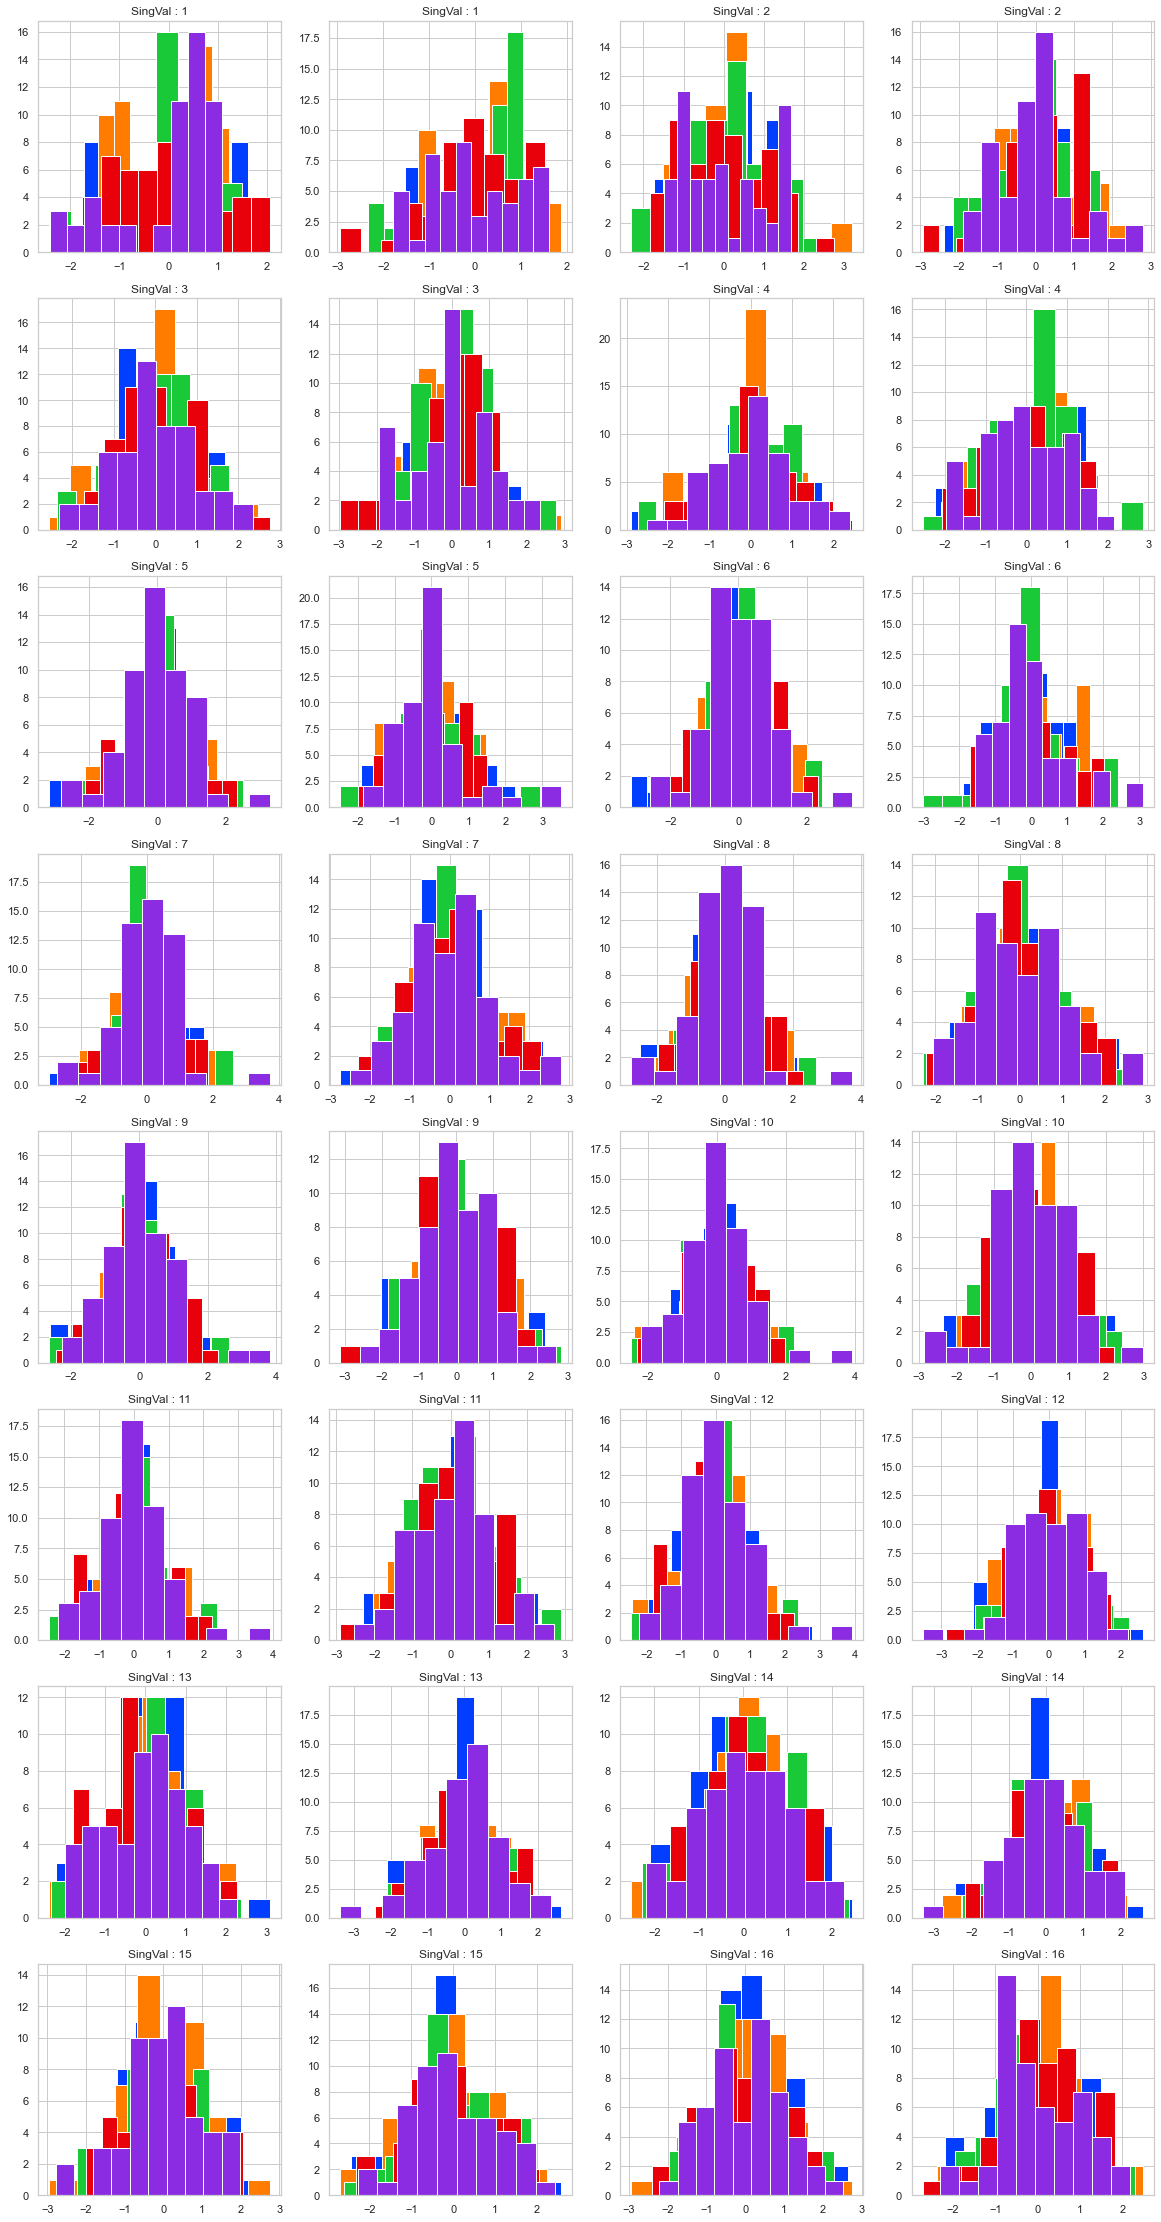

In [12]:
'''
The D statistic is the absolute max distance (supremum) between the CDFs of the two samples.
The closer this number is to 0 the more likely it is that the two samples were drawn from 
the same distribution. Check out the Wikipedia page for the k-s test. It provides a good 
explanation: https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

The p-value returned by the k-s test has the same interpretation as other p-values. 
You reject the null hypothesis that the two samples were drawn from the same distribution 
if the p-value is less than your significance level. The online tables for the 
conversion of the D statistic into a p-value can be found.
'''

fig, axes = plt.subplots(8, 4, figsize = (20, 40))
state_idx = 0
donor = True #set False for the target states
donor_idx = 0
p = 0.95
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))


normal_noise_sv = {}
p_thresh = 0.95

for state_idx in range(5):
    #normal_noise_sv[m.state] = []

    for i in range(16):
        donor_idx = 0
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        axes[(2*i)//4][(2*i)%4].hist(error)
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[(2*i)//4][(2*i)%4].set_title('SingVal : %s'%(i+1))
        (D_statistic,p_value) = kstest(error,'norm')
        #print(p_value)
        if p_value > p_thresh:
            if m.state not in normal_noise_sv:
                normal_noise_sv[m.state] = []
            normal_noise_sv[m.state].append(i)
         
        donor_idx = 1
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        axes[(2*i+1)//4][(2*i+1)%4].hist(error)
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[(2*i+1)//4][(2*i+1)%4].set_title('SingVal : %s'%(i+1))
        (D_statistic,p_value) = kstest(error,'norm')
        #print(p_value)
        if p_value > p_thresh:
            if m.state not in normal_noise_sv:
                normal_noise_sv[m.state] = []
            normal_noise_sv[m.state].append(i)
        
print('normal_noise_sv:', normal_noise_sv)

## correlation between the noise and the signal
Pearson: Used to summarize the strength of the linear relationship between two data samples. The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution. The coefficient returns a value between -1 and 1.




Spearman: Two variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables. Further, the two variables being considered may have a non-Gaussian distribution. In this case, the Spearman’s correlation coefficient (named for Charles Spearman) can be used to summarize the strength between the two data samples. This test of relationship can also be used if there is a linear relationship between the variables, but will have slightly less power (e.g. may result in lower coefficient scores). The coefficient returns a value between -1 and 1.

cov(X, Y) = (sum (x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)

Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))

Spearman's correlation coefficient = covariance(rank(X), rank(Y)) / (stdv(rank(X)) * stdv(rank(Y)))

In [13]:

# seed random number generator
seed(1)
# prepare data
data1 = 20 * randn(1000) + 100
data2 = data1 + (10 * randn(1000) + 50)
# calculate spearman's correlation
corr, _ = spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr)


Spearmans correlation: 0.872


Model fit vs denoiseDF for Niagara-New York
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Niagara-New York 36
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Cumberland-Maine 38
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York 37
Madison-New York

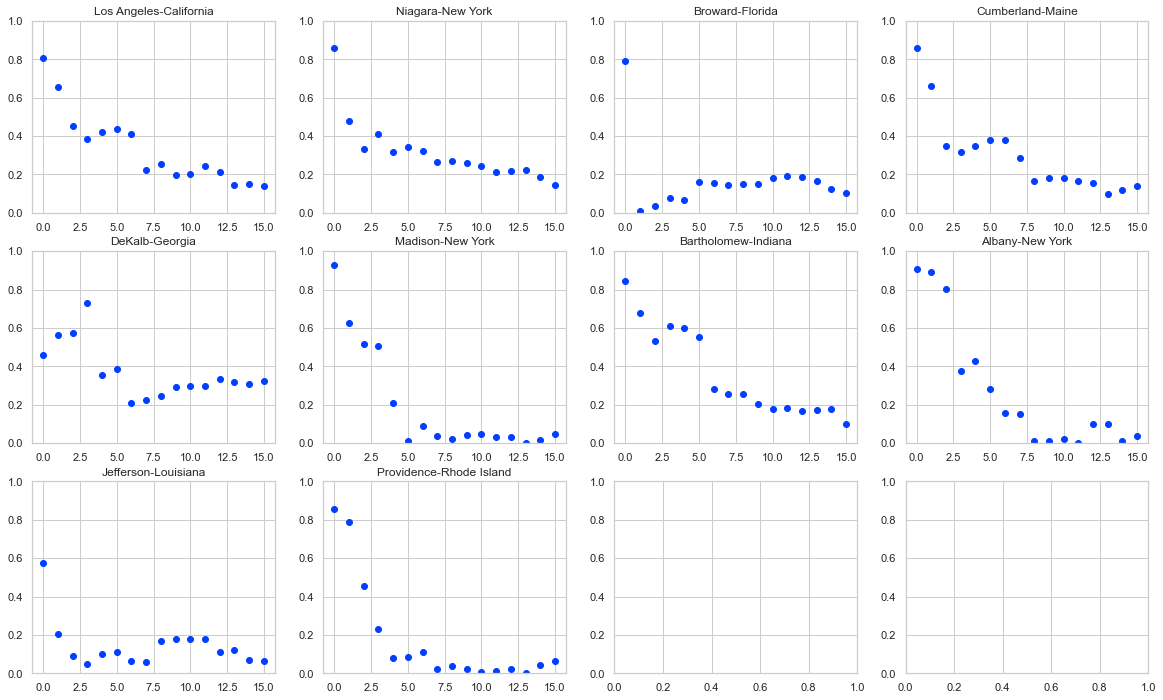

In [14]:
#fig, axes = plt.subplots(4, 4, figsize = (20, 20))
state_idx = 0
donor = True #set False for the target states
donor_idx = 0
p = 0.95
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))

uncorrolated_sv = {}

correlation_val = {}
p_thresh = 0.95

for state_idx in range(5):
    #normal_noise_sv[m.state] = []

    for i in range(16):
        donor_idx = 0
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        # axes[i//4][i%4].hist(error)
        # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        corr, _ = spearmanr(error, m.train[m.state].values)
        
        if abs(corr) < .25 and m.state not in uncorrolated_sv:
            uncorrolated_sv[m.state] = i

        # print(p_value)
        # if p_value > p_thresh:
        if m.state not in correlation_val:
            correlation_val[m.state] = []
        correlation_val[m.state].append((i,corr))
         
        donor_idx = 1
        m = models[i][donor_idx][state_idx]
        print(m.state, len(m.donors))
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        # axes[i//4][i%4].hist(error)
        # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        corr, _ = spearmanr(error, m.train[m.state].values)
        if abs(corr) < .25 and m.state not in uncorrolated_sv:
            uncorrolated_sv[m.state] = i
        #print(p_value)
        #if p_value > p_thresh:
        if m.state not in correlation_val:
            correlation_val[m.state] = []
        correlation_val[m.state].append((i,corr))
        
counties_noise_cor = ceil(len(correlation_val)/4.)
fig, axes = plt.subplots(counties_noise_cor,4, figsize = (20, counties_noise_cor*4))
for i,county in enumerate(correlation_val):      
    sv = [x[0] for x in correlation_val[county]]
    corr = [abs(x[1]) for x in correlation_val[county]]
    axes[i//4][i%4].plot(sv, corr, 'o')
    #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
    axes[i//4][i%4].set_title(county)
    axes[i//4][i%4].set_ylim([0,1])

    #print(i, county)

#print(uncorrolated_sv)
plt.show()


Model fit vs denoiseDF for Niagara-New York
0 Los Angeles-California
1 Niagara-New York
2 Broward-Florida
3 Cumberland-Maine
4 DeKalb-Georgia
5 Madison-New York
6 Bartholomew-Indiana
7 Albany-New York
8 Jefferson-Louisiana
9 Providence-Rhode Island


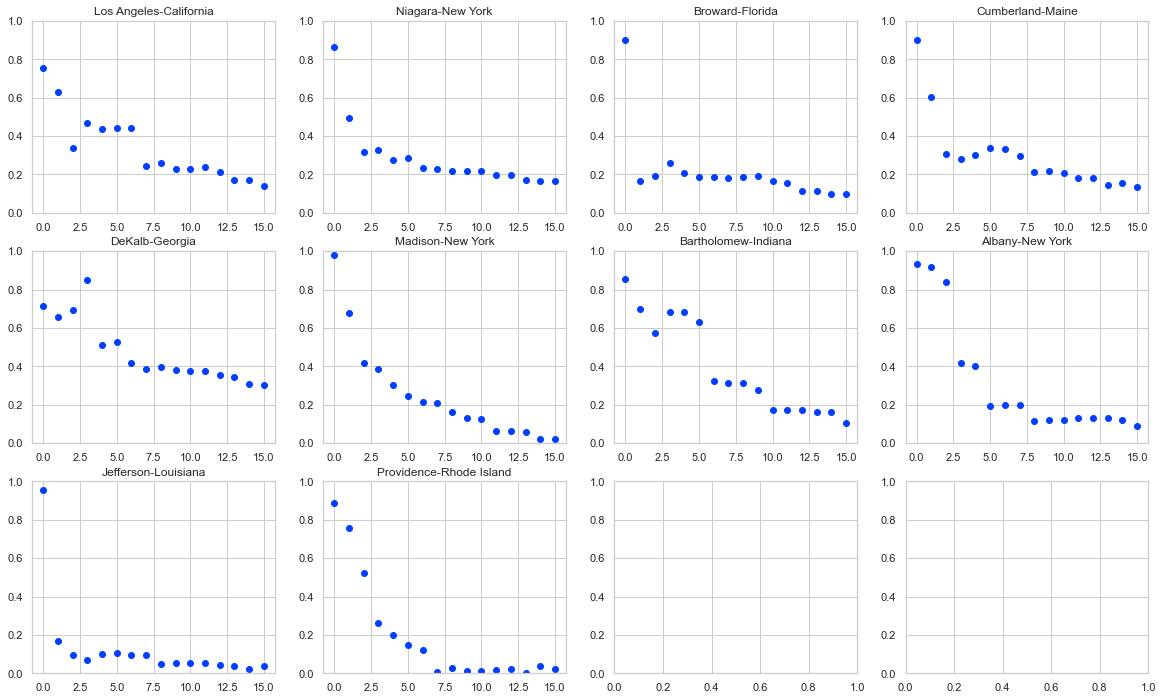

In [15]:
#fig, axes = plt.subplots(4, 4, figsize = (20, 20))
state_idx = 0
donor = True #set False for the target states
donor_idx = 0
p = 0.95
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))


correlation_val = {}
p_thresh = 0.95

for state_idx in range(5):
    #normal_noise_sv[m.state] = []

    for i in range(16):
        donor_idx = 0
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        # axes[i//4][i%4].hist(error)
        # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        corr, _ = pearsonr(error, m.train[m.state].values)
        if abs(corr) < .25 and m.state not in uncorrolated_sv:
            uncorrolated_sv[m.state] = i
        # print(p_value)
        # if p_value > p_thresh:
        if m.state not in correlation_val:
            correlation_val[m.state] = []
        correlation_val[m.state].append((i,corr))
         
        donor_idx = 1
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        # axes[i//4][i%4].hist(error)
        # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        corr, _ = pearsonr(error, m.train[m.state].values)
        if abs(corr) < .25 and m.state not in correlation_val:
            uncorrolated_sv[m.state] = i
        #print(p_value)
        #if p_value > p_thresh:
        if m.state not in correlation_val:
            correlation_val[m.state] = []
        correlation_val[m.state].append((i,corr))
        
counties_noise_cor = ceil(len(correlation_val)/4.)
fig, axes = plt.subplots(counties_noise_cor,4, figsize = (20, counties_noise_cor*4))
for i,county in enumerate(correlation_val):
    sv = [x[0] for x in correlation_val[county]]
    corr = [abs(x[1]) for x in correlation_val[county]]
    axes[i//4][i%4].plot(sv, corr, 'o')
    #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
    axes[i//4][i%4].set_title(county)
    axes[i//4][i%4].set_ylim([0,1])
    print(i, county)
plt.show()



In [16]:
# TODO: write a code t find a good number of singular values. 
# write a function to do auto-correlation and find a good number of sv for the toy example
# Add to the paper that we remove some donorpools that have high error ratio 
# use old data from prop 99


## autocorrelation of the noise

If we choose your cut-off for significance for each lag to be a 95% interval (so we conclude the ACF or PACF at leach lag was non-zero if it was larger in magnitude than the boundary of the 95% interval) then when there were no non-zero population ACF or PACF values, we'd expect to see 5% of your sample values outside the bounds.


| Autocorrelation |  AR(p) | MA(q)| ARMA(p,q)|
| :- | :- | :- | :- |
| ACF | Tails off | Cuts off after lag p | Tails off |
| PACF | Cuts off after lag p | Tails off | Tails off |

for 95% confidence interval, we need to set alpha = 0.05


If p-value < 0.05: You can reject the null hypothesis assuming a 5% chance of making a mistake. So you can assume that your values are showing dependence on each other.

If p-value > 0.05: You don't have enough statistical evidence to reject the null hypothesis. So you can not assume that your values are dependent. This could mean that your values are dependent anyway or it can mean that your values are independent. But you are not proving any specific possibility, what your test actually said is that you can not assert the dependence of the values, neither can you assert the independence of the values.

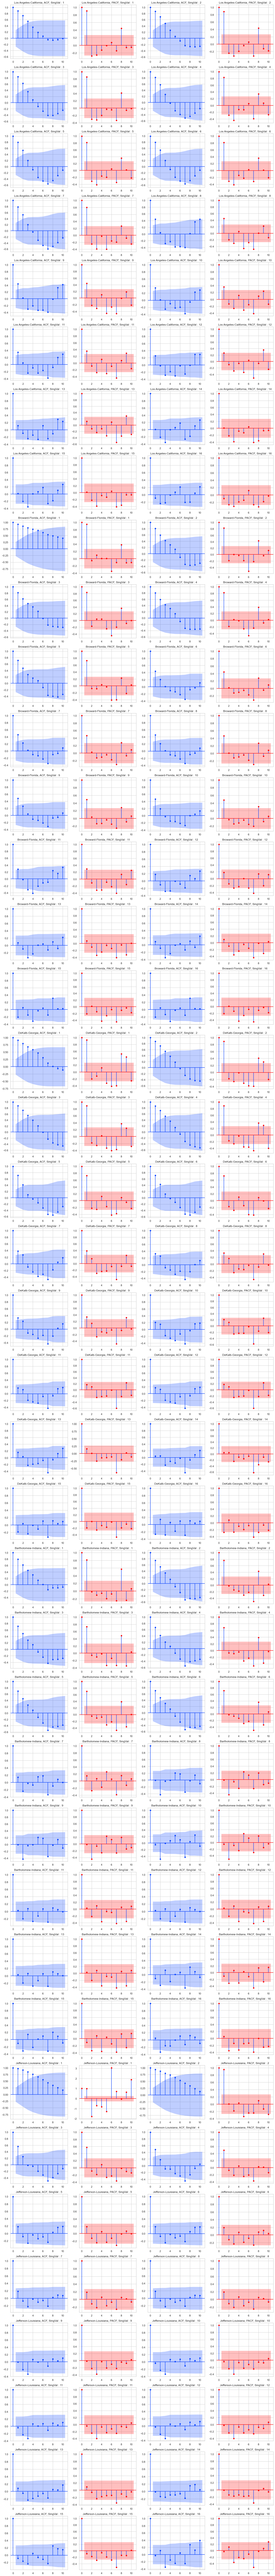

In [17]:
import warnings
import scipy.stats as stats
from collections import defaultdict
#

warnings.filterwarnings('ignore')
fig, axes = plt.subplots(40, 4, figsize = (20, 200))
nlags = 10
states_sv = defaultdict(list)

for state_idx in range(5):
    for i in range(16):
        donor_idx = 0
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        # axes[i//4][i%4].hist(error)
        # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        plot_acf(error, lags=nlags, zero = True, ax = axes[(2*(i+16*state_idx))//4][(2*(i+16*state_idx))%4])
        lag_acf, confint, q_stat, p_values = acf(error, nlags=nlags, alpha=.05, qstat = True)
        #print(lag_acf, confint, q_stat, p_values )
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[(2*(i+16*state_idx))//4][(2*(i+16*state_idx))%4].set_title(m.state +', ACF, SingVal : %s'%(i+1))
        if (p_values>0.05).all():
            states_sv[m.state].append(i+1)
            
        plot_pacf(error, lags=nlags, zero = True, color = "red", ax = axes[((2*(i+16*state_idx))+1)//4][((2*(i+16*state_idx))+1)%4])
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[((2*(i+16*state_idx))+1)//4][((2*(i+16*state_idx))+1)%4].set_title(m.state +', PACF, SingVal : %s'%(i+1))
        #axes[((2*(i+16*state_idx))+1)//4][((2*(i+16*state_idx))+1)%4].collections[PolyCollection].set_facecolor("red")
        
        for item in axes[((2*(i+16*state_idx))+1)//4][((2*(i+16*state_idx))+1)%4].collections:
            #change the color of the CI 
            if type(item)==PolyCollection:
                item.set_facecolor("red")
    
        lag_pacf, confint = pacf(error, nlags=nlags, alpha=.05)
        '''
        donor_idx = 1
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        # axes[i//4][i%4].hist(error)
        # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        plot_acf(error, lags=10, zero = False, ax = axes[((2*(i+16*state_idx))+1)//4][((2*(i+16*state_idx))+1)%4])
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[((2*(i+16*state_idx))+1)//4][((2*(i+16*state_idx))+1)%4].set_title(m.state +', SingVal : %s'%(i+1))
        '''
        


In [18]:
print(states_sv)

defaultdict(<class 'list'>, {'Los Angeles-California': [16], 'DeKalb-Georgia': [15], 'Bartholomew-Indiana': [11, 12, 13], 'Jefferson-Louisiana': [5, 6, 7, 8, 13, 14, 15]})


In [19]:
p_values

array([8.43221613e-01, 7.08332574e-01, 5.35841953e-02, 6.13423882e-02,
       2.64372714e-02, 4.62202322e-02, 1.86700220e-02, 5.50368775e-03,
       6.82653836e-03, 2.68039094e-04])

In [20]:
pop_scaled = create_population_adjusted_data(uscounties_cases, uscounties_population)
#cluster_2_states = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii
cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

        
targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


Los Angeles-California singVals is 11
Niagara-New York singVals is 2


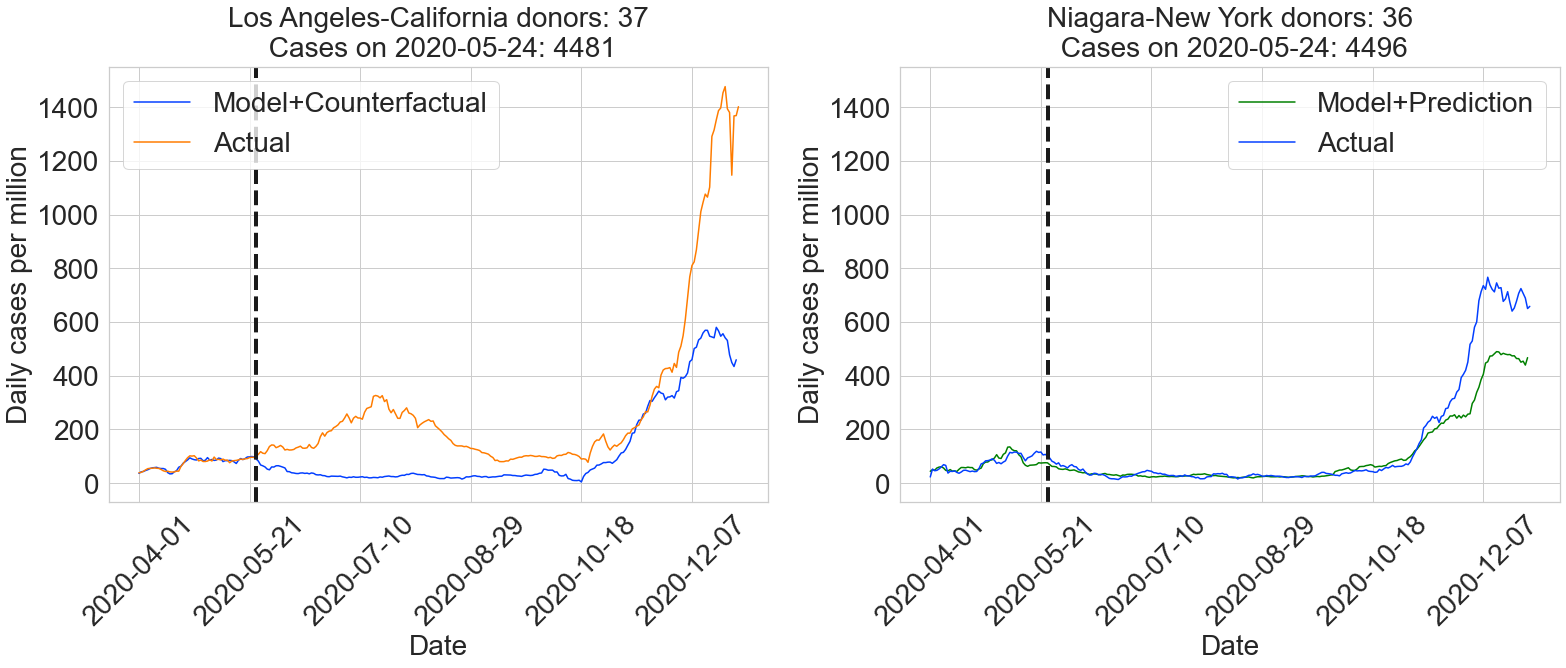

Broward-Florida singVals is 14
Cumberland-Maine singVals is 6


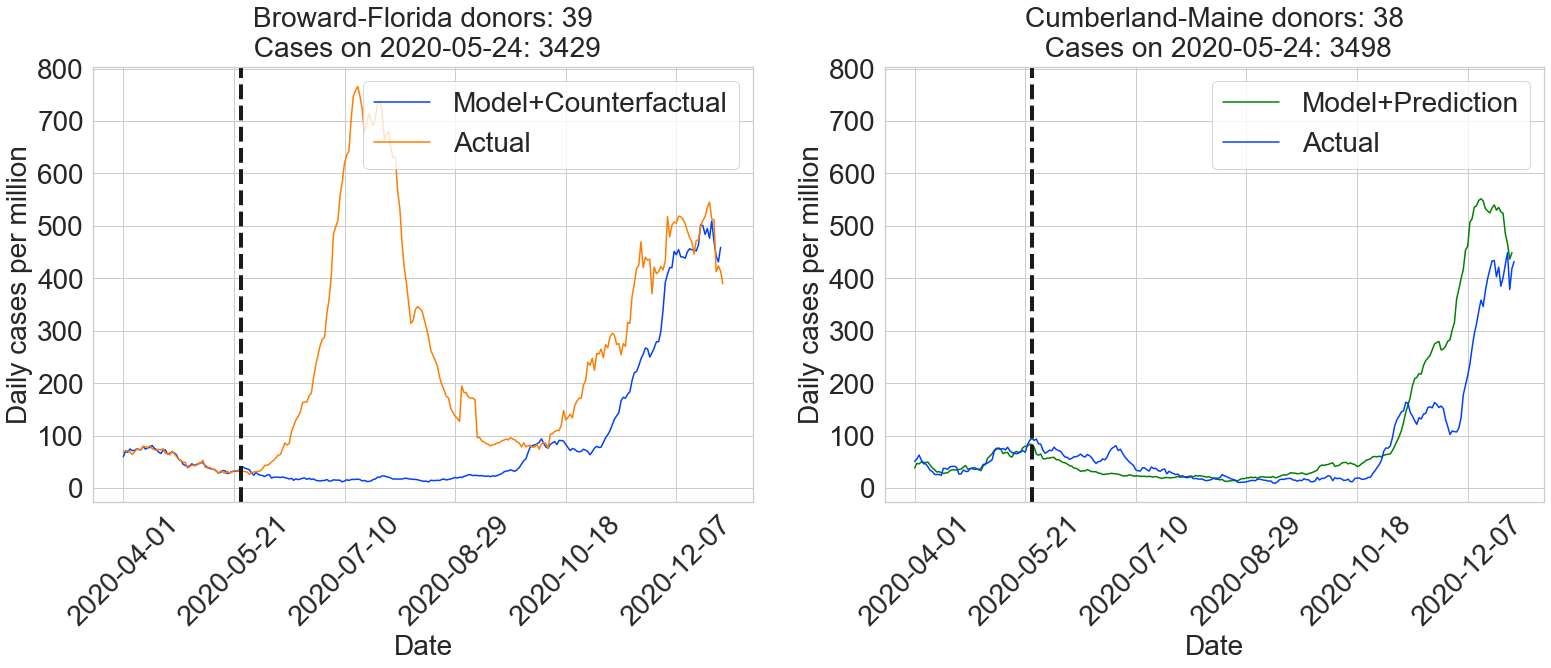

DeKalb-Georgia singVals is 5
Madison-New York singVals is 11


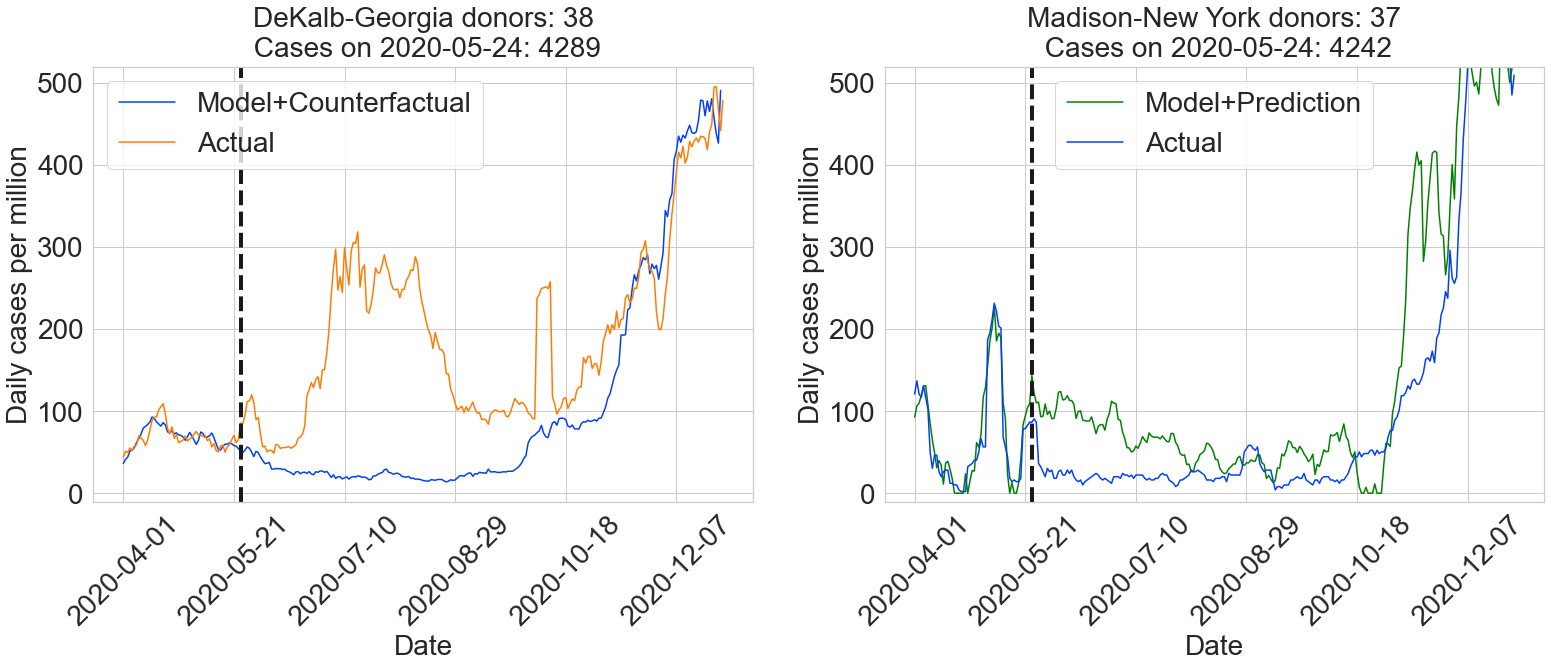

Bartholomew-Indiana singVals is 2
Albany-New York singVals is 3


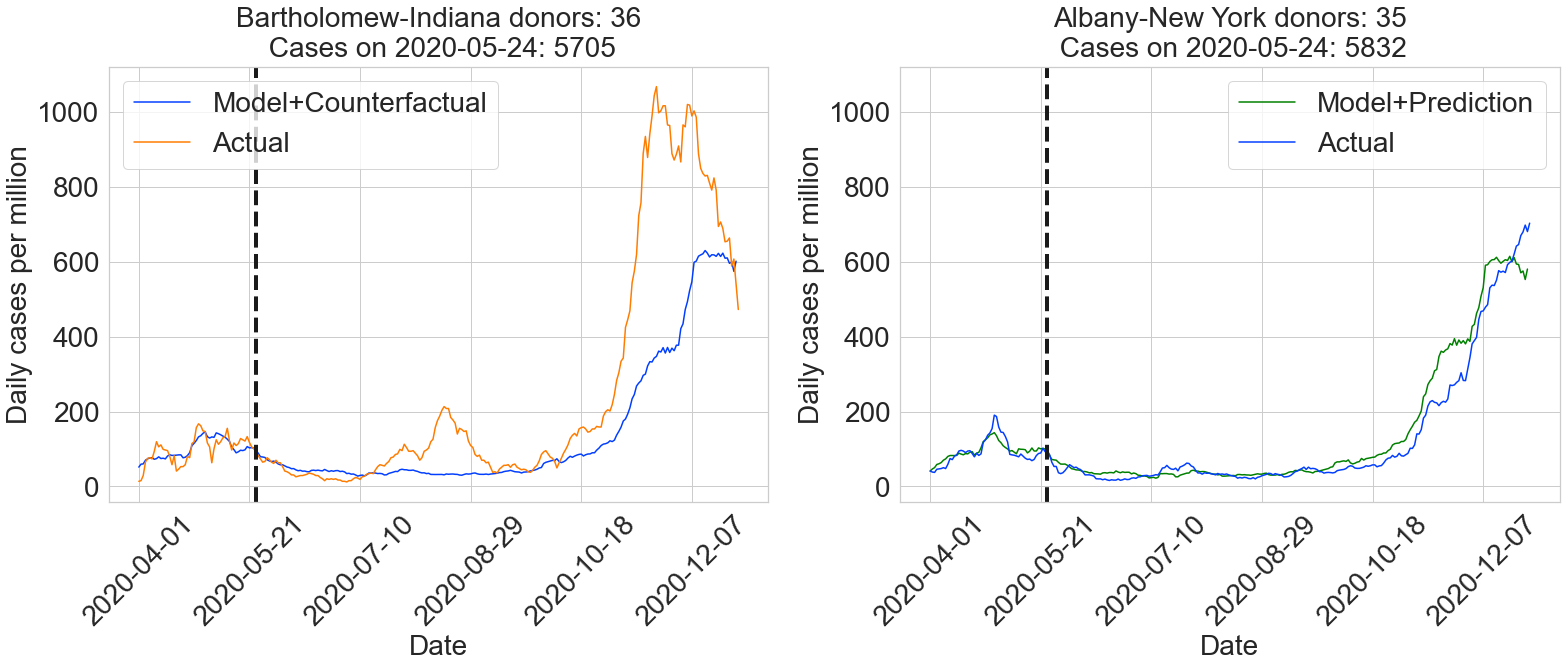

Jefferson-Louisiana singVals is 2
Providence-Rhode Island singVals is 7


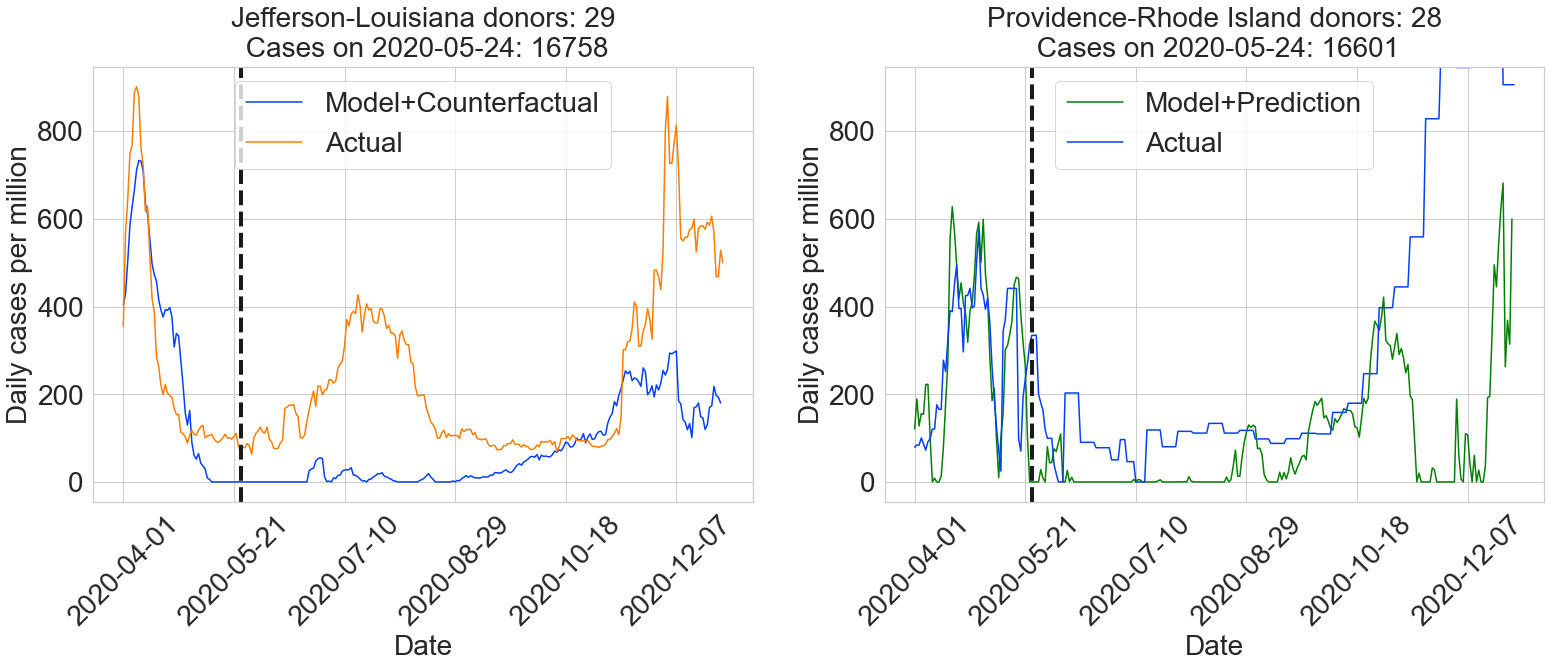

In [21]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in targets:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                       > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit(trainDF)
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    print(model_fit, predictions)
       
        
    '''
    
    singVals = normal_noise_sv[state][0]
    print(state, 'singVals is', singVals)
    
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0
    
    #print(model_fit)
    #continue
        
    
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    #     if(fit_error > 20):
    #         print(state, fit_error)
    #         continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        print(state)
        continue
        


    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), 
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    y_min, y_max = ax.get_ylim()


    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if new_state in otherStates:
        otherStates.remove(new_state)
    
    singVals = normal_noise_sv[new_state][0]
    print(new_state, 'singVals is', singVals)
    
    rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0

    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[new_state][low_thresh+1:])
                                                                                                         
    diversion = find_testing_diversion(df[new_state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][state]

    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")

    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    i=i+1
                                                                                                         
                                                                                                     

    plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()


In [22]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

county_errors = {}

i=1
for state in targets:
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                       > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit(trainDF)
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    print(model_fit, predictions)
       
        
    '''
    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]

    county_errors[state] = []
    county_errors[new_state] = []

    for singVals in range(1,17):
    
    
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)

        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        predictions[predictions < 0 ] = 0 
        model_fit[model_fit < 0] = 0

        #print(model_fit)
        #continue


        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        #print(state, fit_error, prediction_error)
        if(len(otherStates)<5):
            print(otherStates)
            continue
        #     if(fit_error > 20):
        #         print(state, fit_error)
        #         continue
        if((trainDF[state]>10).any()):
            #print(state)
            w=2
        else:
            print(state)
            continue
        diversion = find_testing_diversion(df[new_state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][state]

        county_errors[state].append(diversion)
        

        #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
        #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
        #otherStates = list(otherStates[otherStates.isin(donors)])
        #print(state, "\n", len(otherStates))
        if new_state in otherStates:
            otherStates.remove(new_state)


        rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        predictions[predictions < 0 ] = 0 
        model_fit[model_fit < 0] = 0

        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[new_state][low_thresh+1:])

        diversion = find_testing_diversion(df[new_state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][new_state]
        county_errors[new_state].append(diversion)


In [23]:

for county in county_errors:
    print('\\\\\n', county,  end=' ')
    for err in county_errors[county]:
        print('&', round(err, 3),  end=' ')
    

\\
 Los Angeles-California & 1.444 & 1.732 & 1.634 & 1.138 & 1.059 & 1.076 & 1.011 & 1.427 & 1.668 & 1.298 & 1.36 & 0.935 & 0.873 & 1.41 & 1.526 & 1.495 \\
 Niagara-New York & 1.408 & 2.065 & 1.927 & 1.142 & 1.045 & 1.074 & 1.16 & 1.245 & 1.064 & 1.287 & 1.233 & 1.629 & 1.647 & 2.289 & 2.746 & 2.731 \\
 Broward-Florida & 0.911 & 0.999 & 1.045 & 1.289 & 1.234 & 1.399 & 1.402 & 1.389 & 1.338 & 1.178 & 1.471 & 1.363 & 1.343 & 1.383 & 2.107 & 2.024 \\
 Cumberland-Maine & 0.659 & 0.632 & 0.834 & 1.461 & 1.439 & 1.509 & 1.465 & 0.713 & 0.862 & 0.739 & 0.716 & 0.858 & 0.863 & 0.735 & 0.909 & 0.747 \\
 DeKalb-Georgia & 1.091 & 1.131 & 1.187 & 1.013 & 1.118 & 1.138 & 1.323 & 1.265 & 1.265 & 1.428 & 1.364 & 2.24 & 1.945 & 1.941 & 1.149 & 1.073 \\
 Madison-New York & 1.024 & 2.156 & 6.103 & 6.844 & 6.069 & 5.631 & 5.563 & 5.073 & 2.801 & 2.256 & 1.841 & 26.913 & 27.967 & 25.336 & 49.163 & 51.527 \\
 Bartholomew-Indiana & 0.219 & 0.239 & 0.453 & 0.528 & 0.499 & 0.361 & 0.327 & 0.209 & 0.221 & 0.13

# Province, Rhode Island

Model fit vs denoiseDF for Providence-Rhode Island


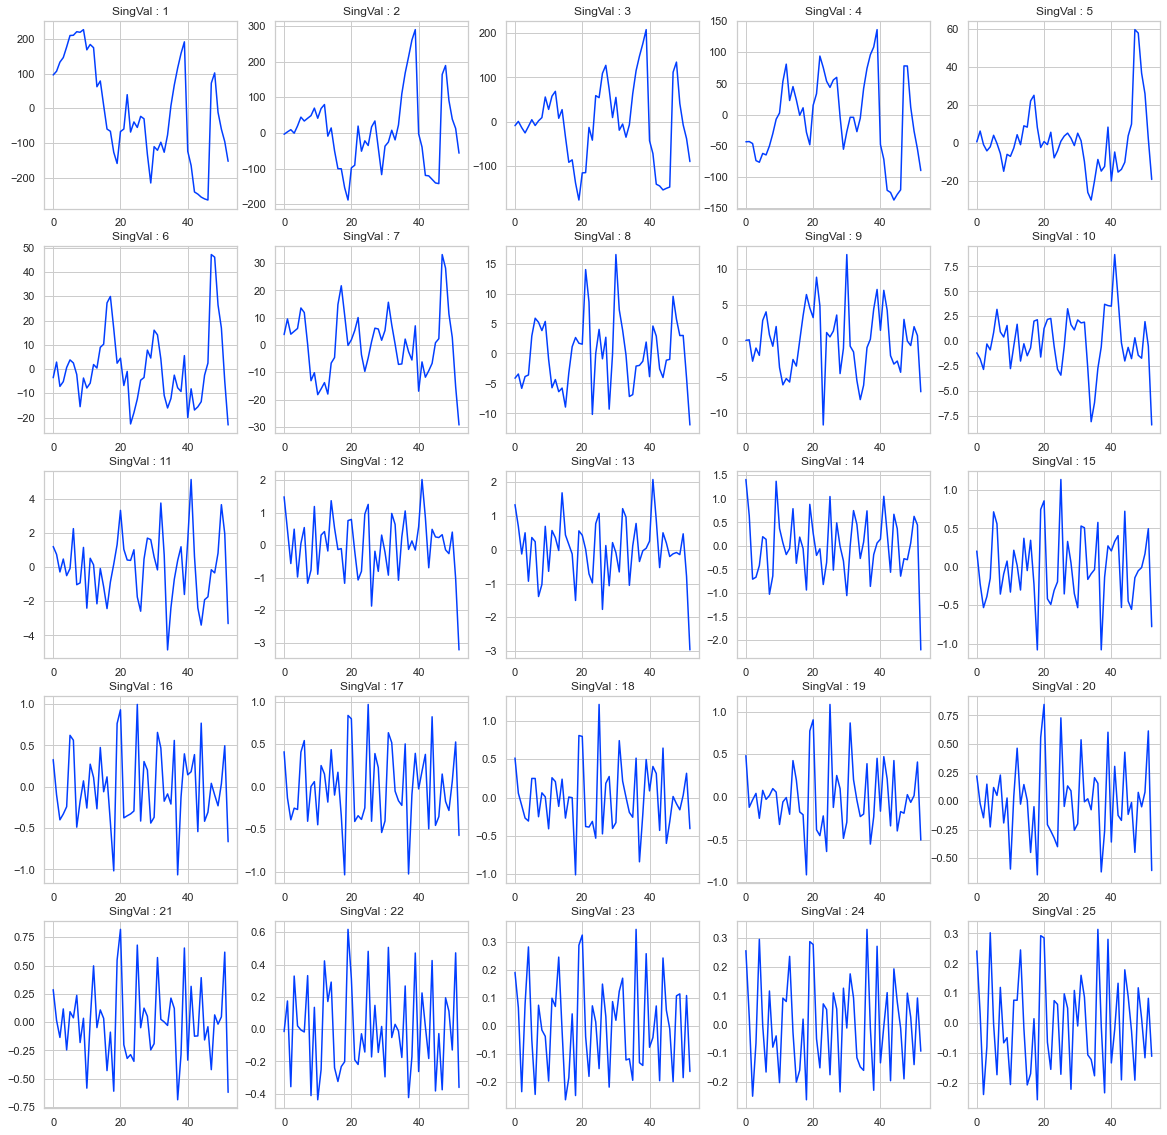

In [24]:
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
state_idx = 4 # state_idx for Rhode-island
donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))

error_mean = []
error_std = []

for i in range(25):
    
    
    m = models[i][donor_idx][state_idx]
    error_list = m.denoisedDF[m.state].values - m.train[m.state].values
    error_mean.append(np.mean(error_list))
    error_std.append(np.std(error_list))
                         
    axes[i//5][i%5].plot(error_list)
    axes[i//5][i%5].set_title('SingVal : %s'%(i+1))

## Singular value threshold in testing (difference between test and actual)

Prediction vs actual for Providence-Rhode Island


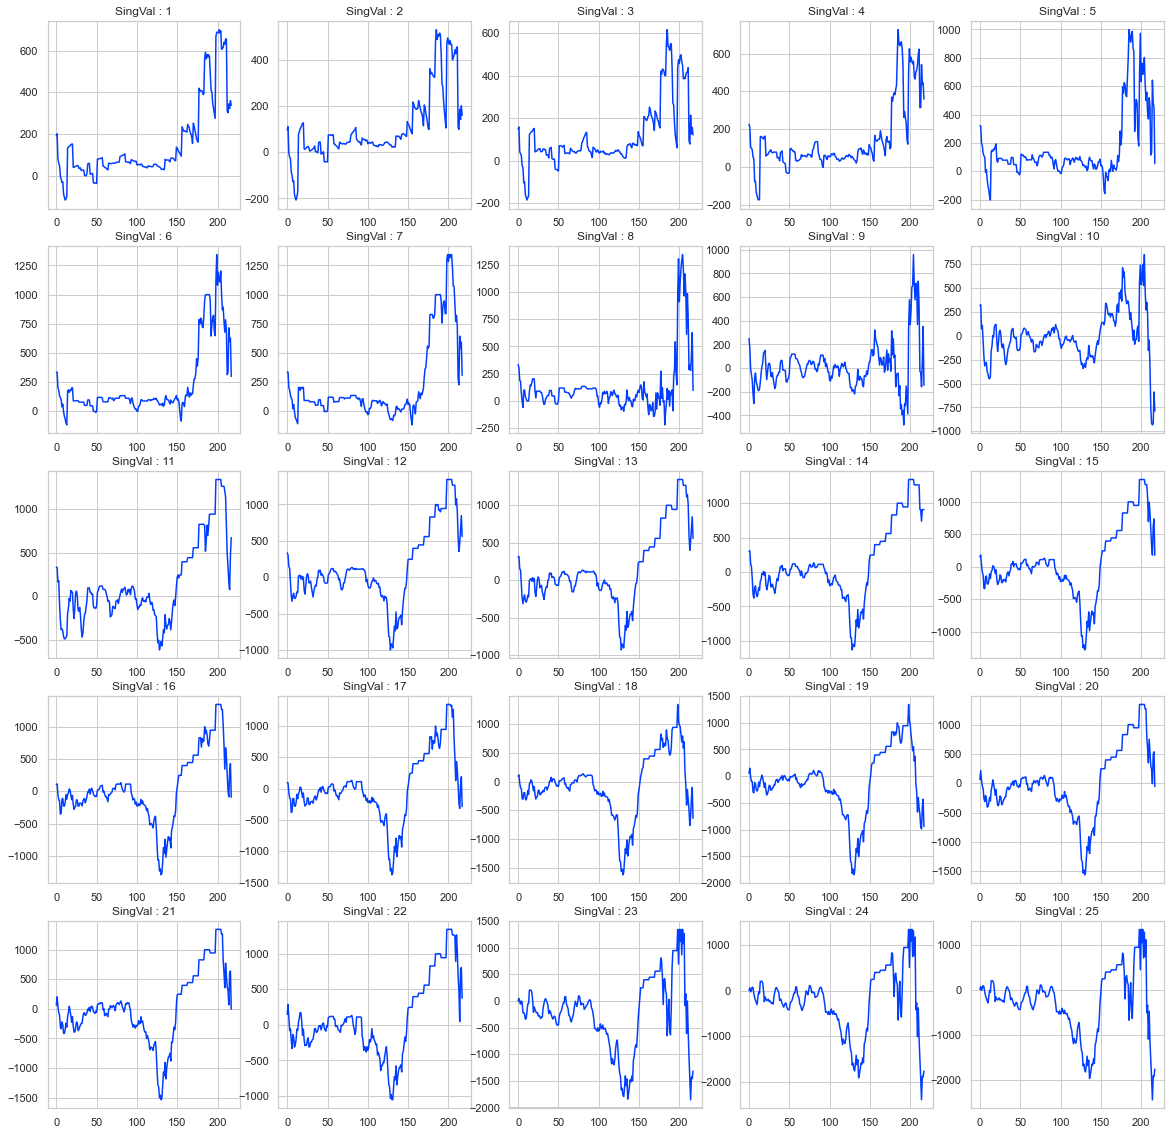

In [25]:
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
state_idx = 4 # state_idx for Rhode-island

donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1

mse_list = []
    
print('Prediction vs actual for %s'%(models[0][donor_idx][state_idx].state))

for i in range(25):
    m = models[i][donor_idx][state_idx]
    error_list = m.actual.values[low_thresh+1:] - m.predictions
    mse_list.append(mean_squared_error(m.actual.values[low_thresh+1:], m.predictions))
    axes[i//5][i%5].plot(error_list)
    axes[i//5][i%5].set_title('SingVal : %s'%(i+1))

In [26]:
# Using the mean for the rows using all the data
X = models[0][donor_idx][state_idx].train
a = np.max(X, axis = 0)
b = np.min(X, axis = 0)
X = (X - (a + b)/2)/((b-a)/2)
mean = np.mean(X, axis = 1)
p = 1
sigma = np.sum(np.square(X[models[0][donor_idx][state_idx].state] - mean))/(len(X)-1)
#sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
s = np.linalg.svd(X)[1]
l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

l = len(s[s > l])
h = len(s[s > h])
l, h

(3, 2)

In [27]:
#X = models[0][donor_idx][state_idx].denoisedDF[models[0][donor_idx][state_idx].state]

# X = models[0][donor_idx][state_idx].actual.values #use the scaler value
# b = np.max(X)
# a = np.min(X)
# X = (X - (a + b)/2)/((b-a)/2)
# p = 1
# variance = np.var(X, ddof = 1)
# l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
# h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
# s = np.linalg.svd(models[0][donor_idx][state_idx].train)[1]
# l = len(s[s > l])
# h = len(s[s > h])

Plots for Providence-Rhode Island


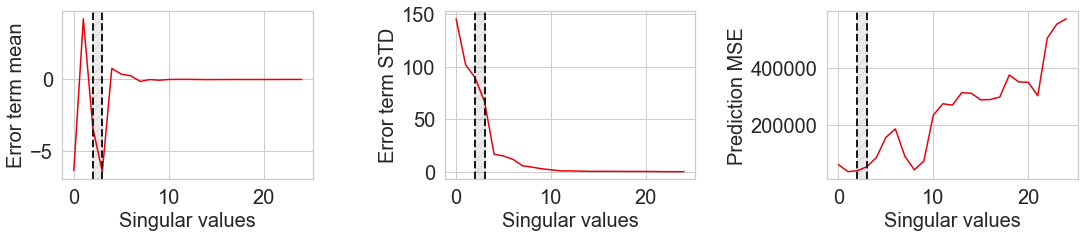

In [28]:

print('Plots for %s'%(models[0][donor_idx][state_idx].state))
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
FONTSIZE = 20

axes[0].plot(error_mean, color='r')
axes[0].set_ylabel('Error term mean', fontsize = FONTSIZE)
axes[0].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[0].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[0].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[0].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[1].plot(error_std, color='r')
axes[1].set_ylabel('Error term STD', fontsize = FONTSIZE)
axes[1].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[1].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[1].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[1].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[2].plot(mse_list, color='r')
axes[2].set_ylabel('Prediction MSE', fontsize = FONTSIZE)
axes[2].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[2].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[2].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[2].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axes[2].yaxis.offsetText.set_fontsize(FONTSIZE)


plt.tight_layout()

plt.savefig("../Figures/traintestrank-providence.pdf")

In [29]:
#models[0][donor_idx][state_idx].train.to_csv("../../Desktop/research/rank_estimation (1)/test.csv")

### trend when filter out some donor pools units

In [30]:
state_idx = 4 # state_idx for Rhode-island
c = 3
donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))

error_mean = []
error_std = []
mse_list = []
df = all_cases_data_pop_daily.loc[start_date:]
for i in range(25):
    
    perm_dict = models[i][donor_idx][state_idx].permutation_distribution(show_graph = False)
    perm_dict.pop(models[i][donor_idx][state_idx].state)
    selected = np.array(list(perm_dict.values()))
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    #print(new_donor, models[i][donor_idx][state_idx].state)

    new_model = syn_model(models[i][donor_idx][state_idx].state,  models[i][0][state_idx].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    
    error_list = new_model.denoisedDF[m.state].values - new_model.train[m.state].values
    error_mean.append(np.mean(error_list))
    error_std.append(np.std(error_list))
    mse_list.append(new_model.test_err)

Model fit vs denoiseDF for Providence-Rhode Island


Plots for Providence-Rhode Island


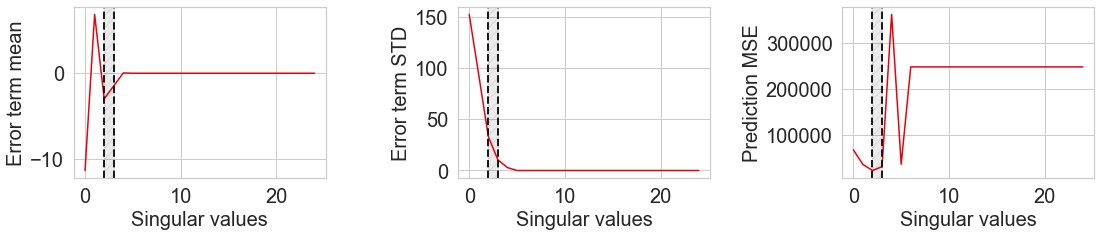

In [31]:

print('Plots for %s'%(models[0][donor_idx][state_idx].state))
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
FONTSIZE = 20

axes[0].plot(error_mean, color='r')
axes[0].set_ylabel('Error term mean', fontsize = FONTSIZE)
axes[0].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[0].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[0].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[0].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[1].plot(error_std, color='r')
axes[1].set_ylabel('Error term STD', fontsize = FONTSIZE)
axes[1].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[1].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[1].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[1].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[2].plot(mse_list, color='r')
axes[2].set_ylabel('Prediction MSE', fontsize = FONTSIZE)
axes[2].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[2].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[2].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[2].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axes[2].yaxis.offsetText.set_fontsize(FONTSIZE)

plt.tight_layout()

plt.savefig("../Figures/traintestrank-providence.pdf")

# Madison, New York

Prediction vs actual for Madison-New York


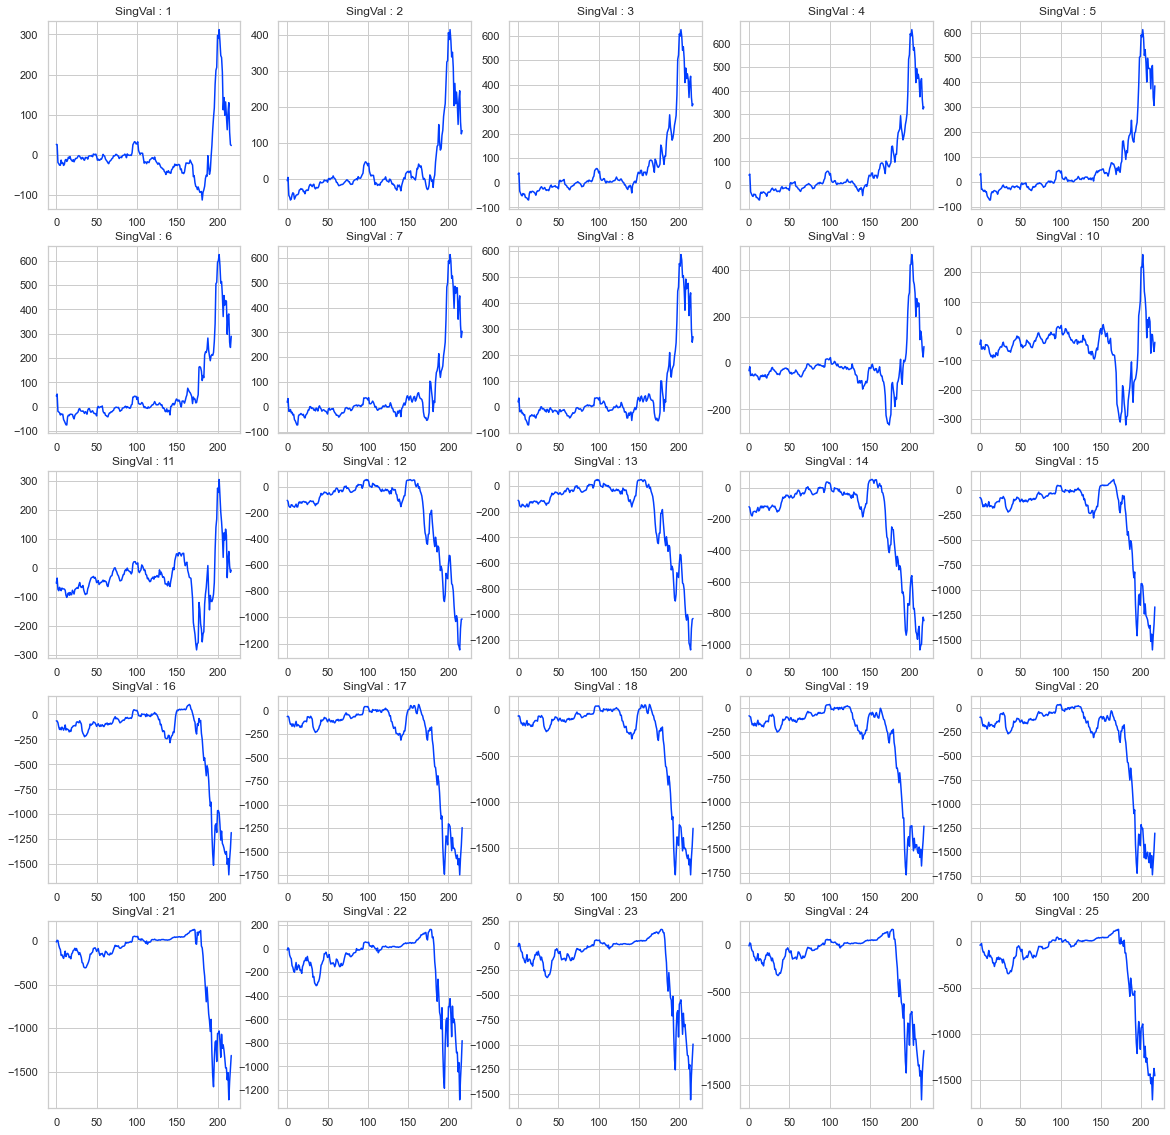

In [32]:
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
state_idx = 2 # state_idx for Madison

donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1

mse_list = []
    
print('Prediction vs actual for %s'%(models[0][donor_idx][state_idx].state))

for i in range(25):
    m = models[i][donor_idx][state_idx]
    error_list = m.actual.values[low_thresh+1:] - m.predictions
    mse_list.append(mean_squared_error(m.actual.values[low_thresh+1:], m.predictions))
    axes[i//5][i%5].plot(error_list)
    axes[i//5][i%5].set_title('SingVal : %s'%(i+1))

In [33]:
# Using the mean for the rows using all the data
X = models[0][donor_idx][state_idx].train
a = np.max(X, axis = 0)
b = np.min(X, axis = 0)
X = (X - (a + b)/2)/((b-a)/2)
mean = np.mean(X, axis = 1)
p = 1
sigma = np.sum(np.square(X[models[0][donor_idx][state_idx].state] - mean))/(len(X)-1)
#sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
s = np.linalg.svd(X)[1]
l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

l = len(s[s > l])
h = len(s[s > h])
l, h

(4, 2)

Plots for Madison-New York


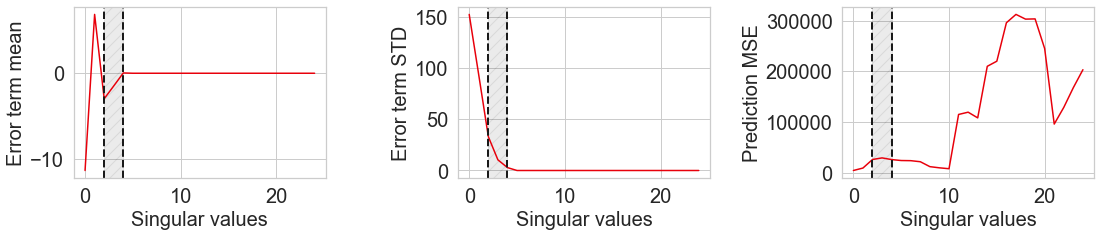

In [34]:

print('Plots for %s'%(models[0][donor_idx][state_idx].state))
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
FONTSIZE = 20

axes[0].plot(error_mean, color='r')
axes[0].set_ylabel('Error term mean', fontsize = FONTSIZE)
axes[0].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[0].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[0].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[0].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[1].plot(error_std, color='r')
axes[1].set_ylabel('Error term STD', fontsize = FONTSIZE)
axes[1].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[1].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[1].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[1].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[2].plot(mse_list, color='r')
axes[2].set_ylabel('Prediction MSE', fontsize = FONTSIZE)
axes[2].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[2].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[2].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[2].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axes[2].yaxis.offsetText.set_fontsize(FONTSIZE)

plt.tight_layout()

plt.savefig("../Figures/traintestrank-madison.pdf")

### trend when filter out some donor pools units

Prediction vs actual for Madison-New York


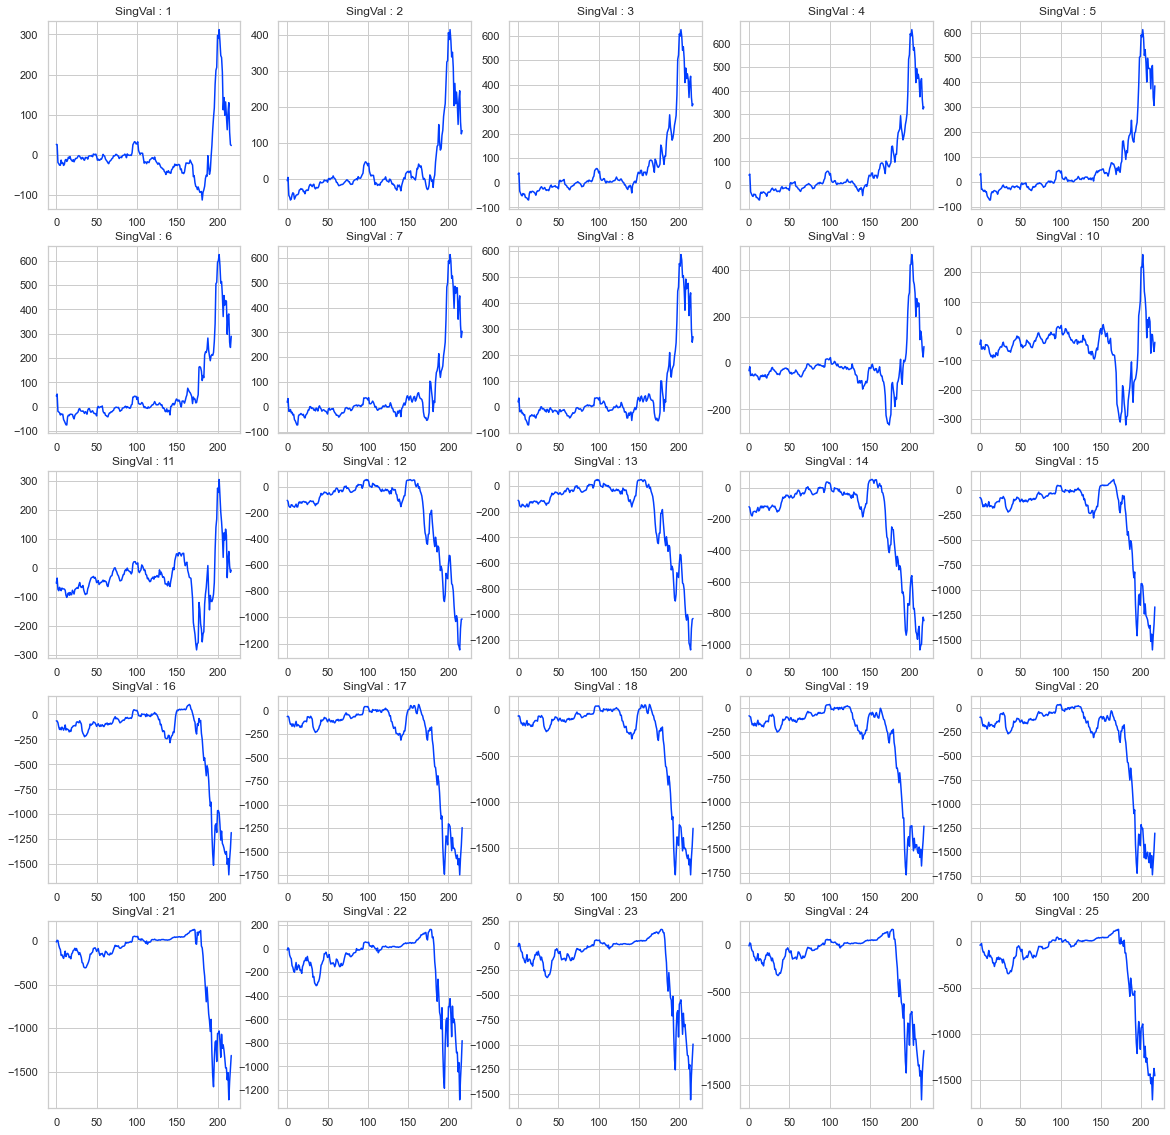

In [35]:
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
state_idx = 2 # state_idx for Madison


donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1

mse_list = []
    
print('Prediction vs actual for %s'%(models[0][donor_idx][state_idx].state))

for i in range(25):
    m = models[i][donor_idx][state_idx]
    error_list = m.actual.values[low_thresh+1:] - m.predictions
    mse_list.append(mean_squared_error(m.actual.values[low_thresh+1:], m.predictions))
    axes[i//5][i%5].plot(error_list)
    axes[i//5][i%5].set_title('SingVal : %s'%(i+1))

In [36]:
# Using the mean for the rows using all the data
X = models[0][donor_idx][state_idx].train
a = np.max(X, axis = 0)
b = np.min(X, axis = 0)
X = (X - (a + b)/2)/((b-a)/2)
mean = np.mean(X, axis = 1)
p = 1
sigma = np.sum(np.square(X[models[0][donor_idx][state_idx].state] - mean))/(len(X)-1)
#sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
s = np.linalg.svd(X)[1]
l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

l = len(s[s > l])
h = len(s[s > h])
l, h

(4, 2)

In [37]:
c = 3
donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))

error_mean = []
error_std = []
mse_list = []
df = all_cases_data_pop_daily.loc[start_date:]
for i in range(25):
    
    perm_dict = models[i][donor_idx][state_idx].permutation_distribution(show_graph = False)
    perm_dict.pop(models[i][donor_idx][state_idx].state)
    selected = np.array(list(perm_dict.values()))
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    #print(new_donor, models[i][donor_idx][state_idx].state)

    new_model = syn_model(models[i][donor_idx][state_idx].state,  models[i][0][state_idx].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    
    error_list = new_model.denoisedDF[m.state].values - new_model.train[m.state].values
    error_mean.append(np.mean(error_list))
    error_std.append(np.std(error_list))
    mse_list.append(new_model.test_err)

Model fit vs denoiseDF for Madison-New York


In [38]:

print('Plots for %s'%(models[0][donor_idx][state_idx].state))
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
FONTSIZE = 20

axes[0].plot(error_mean, color='r')
axes[0].set_ylabel('Error term mean', fontsize = FONTSIZE)
axes[0].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[0].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[0].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[0].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[1].plot(error_std, color='r')
axes[1].set_ylabel('Error term STD', fontsize = FONTSIZE)
axes[1].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[1].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[1].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[1].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[2].plot(mse_list, color='r')
axes[2].set_ylabel('Prediction MSE', fontsize = FONTSIZE)
axes[2]شك.set_xlabel('Singular values', fontsize = FONTSIZE)
axes[2].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[2].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[2].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axes[2].yaxis.offsetText.set_fontsize(FONTSIZE)

plt.tight_layout()

plt.savefig("../Figures/traintestrank-madison.pdf")

SyntaxError: invalid syntax (<ipython-input-38-0585aacb64cd>, line 23)

## Toy example

In [7]:
x = np.arange(1, 100, 1)
a = np.sin(x + 1) * 1
b = np.sin(x/2) * 3
c = np.sin(4*x + 3) * 0.25
d = np.sin(2*x-3) * 0.4
#e = np.sin(5*x-5)*.5
data = a + b + c + d


toy_df = {}
for i in range(50):
    err = 0.1*np.random.uniform(-1,1,size = 99)
    toy_df[i] = np.random.rand() * a + np.random.rand() * b + np.random.rand() * c + np.random.rand() * d + err
    #toy_df[i] = (1.+np.random.rand()) * a + (1.+np.random.rand())  * b + (1.+np.random.rand())  * c + (1.+np.random.rand())  * d + err# (1.+np.random.rand())  * e

toy_df = pd.DataFrame(toy_df)

intervention = 30

In [40]:
toy_df

0         1         2         3         4         5         6   \
0   1.934708  1.256374  0.611123  1.140667  0.537684  1.930833  0.491883   
1   2.675128  1.991158  0.491837  1.471516  1.322981  2.408145  0.309728   
2   2.604388  2.589006  0.023267  1.816564  0.846803  2.133686  0.384294   
3   1.793484  2.227180 -0.507050  1.467027  0.221208  1.387180  0.214460   
4   1.614811  1.325616  0.060253  0.966646  0.828236  1.369174  0.114466   
..       ...       ...       ...       ...       ...       ...       ...   
94 -0.762138 -0.884513  0.160147 -0.509386 -0.310693 -0.400229 -0.147596   
95 -1.994402 -1.985489  0.008956 -1.535356 -0.429788 -1.776056 -0.379382   
96 -2.905444 -2.291587 -0.579337 -1.845084 -1.046627 -2.749256 -0.296477   
97 -3.944315 -2.389803 -1.079780 -2.322833 -1.833720 -3.828186 -0.935026   
98 -2.310649 -1.749664 -0.401560 -1.446194 -0.816612 -2.236985 -0.398126   

          7         8         9   ...        40        41        42        43  \
0   1.876668  0.789026  1.276072  ...  1.007625  1.671068  0.880160  0.672342   
1   1.999598  0.583722  2.161901  ...  1.989651  2.770777  1.403423  0.614304   
2   1.922516  0.363614  2.684842  ...  2.081742  2.582128  1.447593 -0.162491   
3   1.195419 -0.111305  2.167808  ...  1.451115  1.653420  0.991561 -0.832116   
4   1.062121  0.170502  1.590858  ...  1.332930  1.762463  0.835849  0.093522   
..       ...       ...       ...  ...       ...       ...       ...       ...   
94 -0.241544  0.115373 -1.110796  ... -0.766167 -0.831193 -0.494170  0.367278   
95 -1.558588 -0.350490 -2.051535  ... -1.422794 -1.929056 -1.144352  0.183006   
96 -2.399803 -0.735653 -2.422525  ... -2.025663 -2.911468 -1.391901 -0.509304   
97 -3.402387 -1.420471 -2.766754  ... -2.675632 -3.847137 -2.203411 -1.711389   
98 -2.027918 -0.758429 -1.750887  ... -1.577737 -2.268917 -1.264203 -0.601448   

          44        45        46        47        48        49  
0   0.499810  1.303883  1.142355  0.838180  0.316685  1.089662  
1   0.618015  1.001989  1.601842  0.726608  0.477170  1.737484  
2   0.541583  0.903988  2.176475 -0.011766  0.321607  1.919876  
3   0.365415  0.214179  1.640153 -0.594610 -0.166670  1.660644  
4   0.257523  0.423647  1.073198  0.317211  0.149654  1.264127  
..       ...       ...       ...       ...       ...       ...  
94 -0.174817 -0.052880 -0.925287  0.375221 -0.165957 -0.837410  
95 -0.450793 -0.785652 -1.545028 -0.050967 -0.105722 -1.487479  
96 -0.662026 -1.206482 -1.767760 -0.859274 -0.232196 -1.895258  
97 -1.024412 -2.349612 -2.263346 -1.802228 -1.051061 -2.057553  
98 -0.556545 -1.251220 -1.355602 -0.756179 -0.384957 -1.360117  

[99 rows x 50 columns]

In [41]:
#scaler
np.sum(np.square((toy_df[0][:intervention] - toy_df.iloc[:intervention][0].mean())))/(intervention-1)

4.764599425959642

In [42]:
m = syn_model(0, 4, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
m.fit_model(force_positive=False)

In [43]:
#vector
np.sum(np.square((toy_df[0][:intervention] - m.denoisedDF[0])))/(intervention-1)

0.0038238778502489705

In [44]:
#by mean vector
X = m.train
mean = np.mean(X, axis = 1)
sigma = np.sum(np.square(X[0] - mean))/(intervention-1)
sigma

1.167208882323513

In [45]:
print(toy_df)

          0         1         2         3         4         5         6   \
0   1.934708  1.256374  0.611123  1.140667  0.537684  1.930833  0.491883   
1   2.675128  1.991158  0.491837  1.471516  1.322981  2.408145  0.309728   
2   2.604388  2.589006  0.023267  1.816564  0.846803  2.133686  0.384294   
3   1.793484  2.227180 -0.507050  1.467027  0.221208  1.387180  0.214460   
4   1.614811  1.325616  0.060253  0.966646  0.828236  1.369174  0.114466   
..       ...       ...       ...       ...       ...       ...       ...   
94 -0.762138 -0.884513  0.160147 -0.509386 -0.310693 -0.400229 -0.147596   
95 -1.994402 -1.985489  0.008956 -1.535356 -0.429788 -1.776056 -0.379382   
96 -2.905444 -2.291587 -0.579337 -1.845084 -1.046627 -2.749256 -0.296477   
97 -3.944315 -2.389803 -1.079780 -2.322833 -1.833720 -3.828186 -0.935026   
98 -2.310649 -1.749664 -0.401560 -1.446194 -0.816612 -2.236985 -0.398126   

          7         8         9   ...        40        41        42        43  \
0   1.

In [46]:
import rank_estimation
rank = 0
for i in range(100):
    #m = syn_model(0, i, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    #m.fit_model(force_positive=False)
    #rank = m.estimate_singVal()
    rank += estimate_rank(toy_df.values)
    
numerical_rank = round(rank/100)
print(numerical_rank)

2


In [47]:

warnings.filterwarnings('ignore')
fig, axes = plt.subplots(15, 4, figsize = (20, 75))
nlags = 10
valid_sv = []

for i in range(30):
    m = syn_model(0, i+1, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    m.fit_model(force_positive=False)
    error = (m.denoisedDF[m.state].values - m.train[m.state].values)
    error = (error - error.mean()) / error.std()
    # axes[i//4][i%4].hist(error)
    # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
    plot_acf(error, lags=nlags, zero = False, ax = axes[(2*(i))//4][(2*(i))%4])
    lag_acf, confint, q_stat, p_values = acf(error, nlags=nlags, alpha=.05, qstat = True)
    #print(lag_acf, confint, q_stat, p_values )
    #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
    axes[(2*(i))//4][(2*(i))%4].set_title('ACF, SingVal : %s'%(i+1))
    if (p_values>0.05).all():
        
        valid_sv.append([i+1,p_values.mean()])

    plot_pacf(error, lags=nlags, zero = False, color = "red", ax = axes[((2*(i))+1)//4][((2*(i))+1)%4])
    #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
    axes[((2*(i))+1)//4][((2*(i))+1)%4].set_title('PACF, SingVal : %s'%(i+1))

    for item in axes[((2*(i))+1)//4][((2*(i))+1)%4].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor("red")

    lag_pacf, confint = pacf(error, nlags=nlags, alpha=.05)


print(valid_sv)
auto_rank = valid_sv[0][0]
print(auto_rank)

[[4, 0.3550053134223178], [5, 0.6826165511654005], [6, 0.725150840625841], [7, 0.7031279942954409], [10, 0.35127142869752104], [11, 0.643699446797233], [12, 0.2458810297716386], [19, 0.30851493323493107], [20, 0.3177773037608479], [22, 0.8629446912733684], [23, 0.8917526396018142], [24, 0.1691668065830525], [25, 0.1949894990023747], [26, 0.1980390730739146], [27, 0.5172819302602225], [28, 0.7837783238065557], [29, 0.5392880291895384]]
4


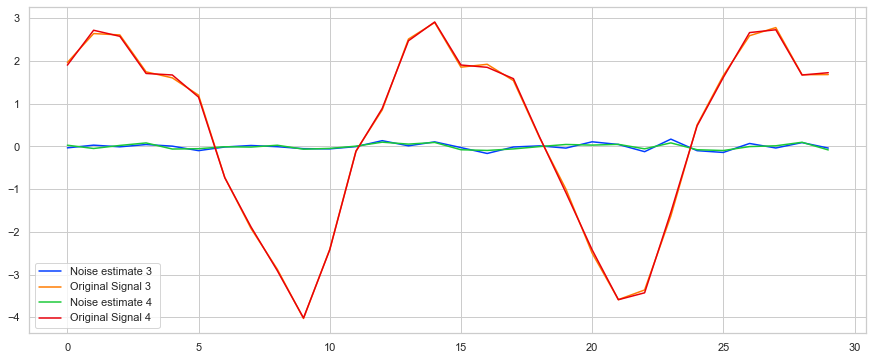

In [48]:
m = syn_model(0, numerical_rank, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
m.fit_model(force_positive=False)

fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - m.denoisedDF[0], label='Noise estimate 3')
#plt.plot(toy_df[0][0:intervention], label='Original Signal 3')
plt.plot(m.denoisedDF[0], label='Original Signal 3')

#plt.plot(X[0] - mean, label='Mean Vector')

m = syn_model(0, 4, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
m.fit_model(force_positive=False)

#fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - m.denoisedDF[0], label='Noise estimate 4 ')
plt.plot(m.denoisedDF[0], label='Original Signal 4')


plt.legend()


#plt.savefig("../Figures/correctestimate.pdf")


In [49]:
def build_toy_signal():
    x = np.arange(1, 100, 1)
    a = np.sin(x + 1) * 1
    b = np.sin(x/2) * 3
    c = np.sin(4*x + 3) * 0.25
    d = np.sin(2*x-3) * 0.4
    #e = np.sin(5*x-5)*.5

    toy_df = {}
    for i in range(50):
        err = 0.1*np.random.uniform(-1,1,size = 99)
        toy_df[i] = np.random.rand() * a + np.random.rand() * b + np.random.rand() * c + np.random.rand() * d + err
        #toy_df[i] = (1.+np.random.rand()) * a + (1.+np.random.rand())  * b + (1.+np.random.rand())  * c + (1.+np.random.rand())  * d + err# (1.+np.random.rand())  * e

    toy_df = pd.DataFrame(toy_df)
    return toy_df


In [50]:
def find_auto_rank(toy_df, intervention):
    nlags = 10
    valid_sv = []

    for i in range(30):
        m = syn_model(0, i+1, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
        m.fit_model(force_positive=False)
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()

        lag_acf, confint, q_stat, p_values = acf(error, nlags=nlags, alpha=.05, qstat = True)
        lag_pacf, confint = pacf(error, nlags=nlags, alpha=.05)
        if (p_values>0.05).all():
            valid_sv.append([i+1,p_values.mean()])

    auto_rank = valid_sv[0][0]
    return auto_rank

In [51]:
import rank_estimation
intervention = 30
actual_rank = 4

MSE_num = 0
MSE_auto = 0
correct_num = 0
correct_auto = 0

for i in range(100):
    
    toy_df = build_toy_signal()
    m = syn_model(0, actual_rank, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    m.fit_model(force_positive=False)

    numerical_rank = estimate_rank(toy_df.values)
    
    auto_rank =find_auto_rank(toy_df, intervention)
    #print(numerical_rank, auto_rank)
    
    correct_num += (numerical_rank == actual_rank)
    correct_auto += (auto_rank == actual_rank)
    
    m_num = syn_model(0, numerical_rank, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    m_num.fit_model(force_positive=False)

    m_auto = syn_model(0, auto_rank, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    m_auto.fit_model(force_positive=False)

    MSE_num += mean_squared_error(m.denoisedDF[0], m_num.denoisedDF[0])
    MSE_auto += mean_squared_error(m.denoisedDF[0], m_auto.denoisedDF[0])
    #if auto_rank == actual_rank:
    #    print(mean_squared_error(m.denoisedDF[0], m_auto.denoisedDF[0]))
    
MSE_num /= 100
MSE_auto /= 100
print(MSE_num, MSE_auto)
print(correct_num, correct_auto)


0.021892462767832695 0.0003708539759112586
0 49


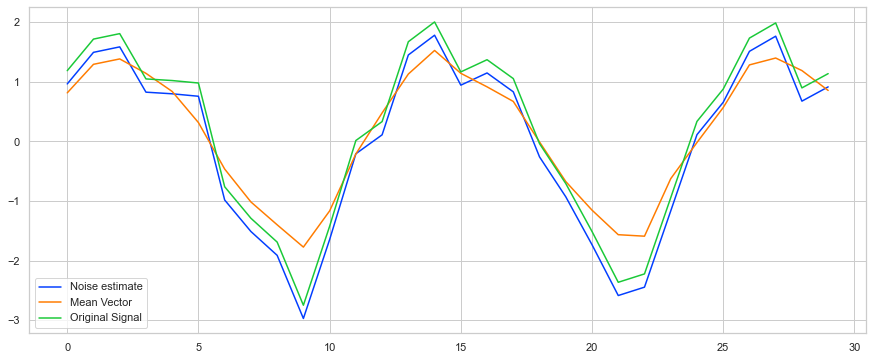

In [52]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - toy_df.iloc[:intervention][0].mean(), label='Noise estimate')
plt.plot(X[0] - mean, label='Mean Vector')
plt.plot(toy_df[0][0:intervention], label='Original Signal')
plt.legend()
plt.savefig("../Figures/faultyestimate.pdf")
#plt.plot(toy_df[0][:intervention] - m.denoisedDF[0])

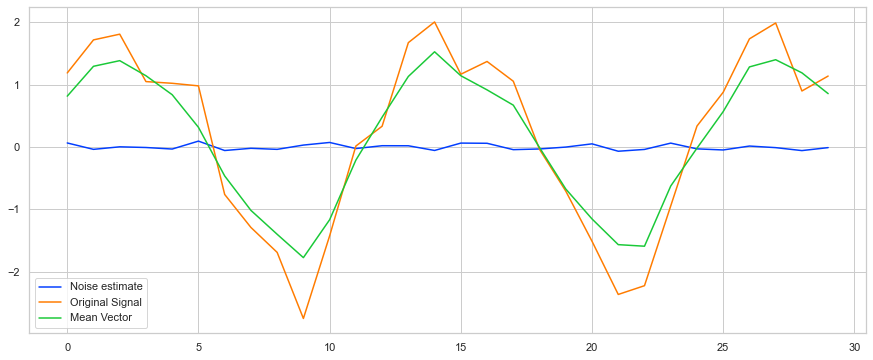

In [53]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - m.denoisedDF[0], label='Noise estimate')
plt.plot(toy_df[0][0:intervention], label='Original Signal')
plt.plot(X[0] - mean, label='Mean Vector')
plt.legend()

plt.savefig("../Figures/correctestimate.pdf")
#plt.plot(toy_df[0][:intervention] - m.denoisedDF[0])

{0: 1}


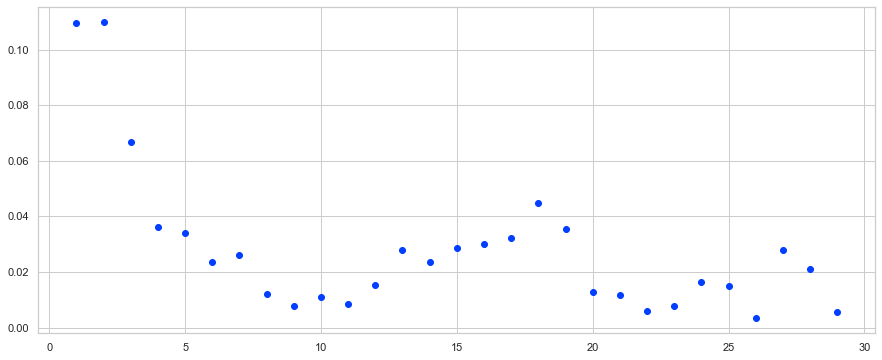

In [54]:
#fig, axes = plt.subplots(4, 4, figsize = (20, 20))

uncorrolated_sv = {}

correlation_val = []


for i in range(1,30):
    m = syn_model(0, i, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    m.fit_model(force_positive=False)
    error = (m.denoisedDF[m.state].values - m.train[m.state].values)
    error = (error - error.mean()) / error.std()
    # axes[i//4][i%4].hist(error)
    # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
    corr, _ = pearsonr(error, m.train[m.state].values) #pearsonr # spearmanr

    if abs(corr) < .25 and m.state not in uncorrolated_sv:
        uncorrolated_sv[m.state] = i

    # print(p_value)
    # if p_value > p_thresh:

    correlation_val.append((i,corr))

        
counties_noise_cor = ceil(len(correlation_val)/4.)
fig, ax = plt.subplots(1,1, figsize = (15, 6))

sv = [x[0] for x in correlation_val]
corr = [abs(x[1]) for x in correlation_val]
ax.plot(sv, corr, 'o')
#axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)


print(uncorrolated_sv)
plt.show()


{0: 1}


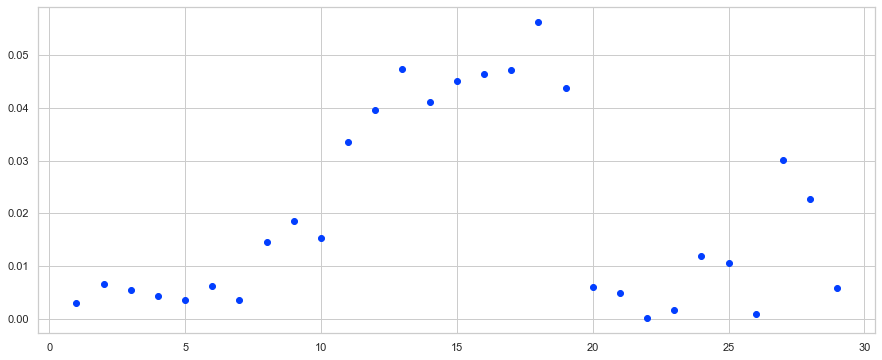

In [63]:
#fig, axes = plt.subplots(4, 4, figsize = (20, 20))

uncorrolated_sv = {}

correlation_val = []


for i in range(1,30):
    m = syn_model(0, i, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
    m.fit_model(force_positive=False)
    error = (m.denoisedDF[m.state].values - m.train[m.state].values)
    error = (error - error.mean()) / error.std()
    # axes[i//4][i%4].hist(error)
    # axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
    corr = pd.Series(error).corr(m.denoisedDF[m.state]) #pearsonr # spearmanr

    if abs(corr) < .25 and m.state not in uncorrolated_sv:
        uncorrolated_sv[m.state] = i

    # print(p_value)
    # if p_value > p_thresh:

    correlation_val.append((i,corr))

        
counties_noise_cor = ceil(len(correlation_val)/4.)
fig, ax = plt.subplots(1,1, figsize = (15, 6))

sv = [x[0] for x in correlation_val]
corr = [abs(x[1]) for x in correlation_val]
ax.plot(sv, corr, 'o')
#axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)


print(uncorrolated_sv)
plt.show()


In [56]:
#problems:
# 1. we don't have 76≤ 𝑚 ≤𝑛
# 2. in fast comp, it doesnt' say to normalize X, and probably shouldn't case we are giving higher weight to bigger elements
# 3. p is a parameter
# 4. the second term in equation 6 of our writeup end up being larger than 1 for some p

def compute_low_rank_appx(Y): 
    # we assume that Y is an m*n matrix, where 76≤ 𝑚 ≤𝑛
    # and all elements are normalized to 1.
    # assert(76<=Y.shape[0] <= Y.shape[1])
    # assert((Y<= 1).all)
    p = 0.00001
    b = np.max(abs(Y), axis = 0)
    n = max(Y.shape)
    print(n)
    C = (8 * np.log(n))**4 / n
    p_ij = np.maximum(p*Y**2/b**2, Y*(p*C)**.5/b)
    #print(p_ij)
    #print("Values bigger than 1 =", p_ij[np.logical_and(p_ij<1 , p_ij>0)])
    
    #p_ij = p_ij.fillna(0)
    print("Values smaller than 0 =", p_ij[p_ij<0])
    
    print("Values larger than 1 =", p_ij[p_ij>1])
    print(p_ij.shape,len(p_ij[p_ij>1]))
    
    #print("Values Nan = ", p_ij[p_ij==None])
    #print("Their indices are ", np.nonzero(p_ij==None))
    
    Y_hat_ij  = (Y/p_ij)
    idx = np.random.binomial(1,p_ij,p_ij.shape)
    Y_hat_ij[idx ==0 ] = 0.
    return Y_hat_ij
            
# Using the mean for the rows using all the data
X = m.train # models[0][donor_idx][state_idx].train
#print(X[X.isna()])
X.dropna(how='any', inplace = True)
#X = X.values
#print(X[X <0])

#print((X == X2).all())

a = np.min(X, axis = 0)
b = np.max(X, axis = 0)
X = (X - (a + b)/2)/((b-a)/2)
#print(X[X <0])
mean = compute_low_rank_appx(X.values.T)
mean = pd.DataFrame(mean.T, columns=X.columns, index=X.index)

#mean = compute_low_rank_appx(X, p = 1)
p = 1
sigma = np.sum(np.square(X[0] - mean[0]))/(len(X)-1)
#sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
s = np.linalg.svd(X)[1]
l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

l = len(s[s > l])
h = len(s[s > h])
l, h


50
Values smaller than 0 = []
Values larger than 1 = []
(50, 30) 0


(1, 1)

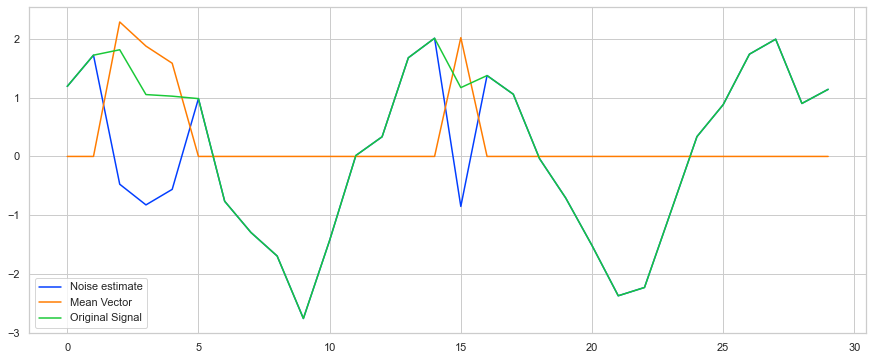

In [57]:

fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - mean[0], label='Noise estimate')
plt.plot(mean[0], label='Mean Vector')
plt.plot(toy_df[0][0:intervention], label='Original Signal')
plt.legend()



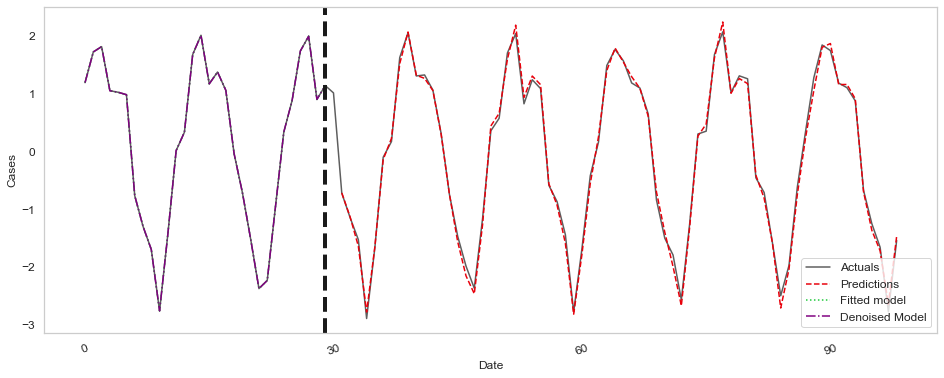

In [58]:
m.plot(show_denoise = True)

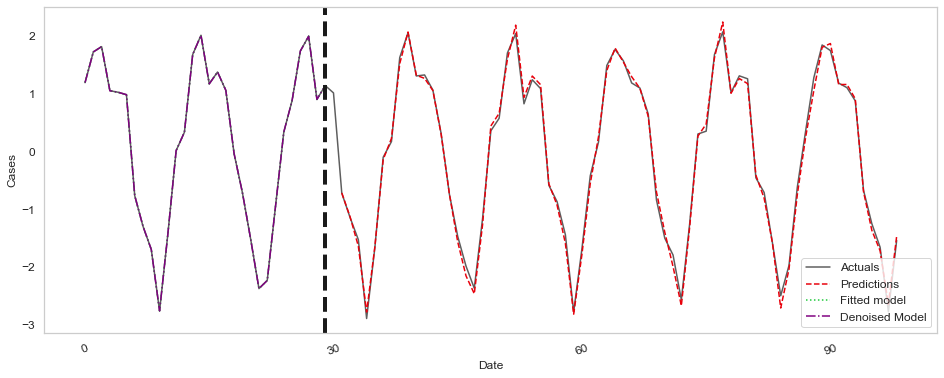

In [59]:
m.plot(show_denoise = True)

In [60]:
m.svd_spectrum(show_plot = True)

(array([[-0.13960552,  0.17978791, -0.26297366, -0.08629752, -0.20680776,
          0.1544259 , -0.35972743,  0.18791631, -0.09153742, -0.17689289,
          0.34347763, -0.04973497, -0.08179267, -0.2687076 ,  0.07283874,
          0.08026673,  0.0785282 ,  0.1691612 , -0.24174761, -0.07017575,
         -0.22633027,  0.14143669,  0.02097066,  0.37701303, -0.09823983,
         -0.02518431, -0.05823501, -0.09250446,  0.1482034 , -0.18257419],
        [-0.19720804,  0.02377483,  0.20202973,  0.25748877, -0.1618818 ,
         -0.07423865,  0.27588131, -0.30442059, -0.10903976, -0.36154813,
         -0.08039496, -0.28707409, -0.2306842 ,  0.01001128,  0.09115223,
         -0.08116778, -0.0924827 ,  0.19199592,  0.0609626 , -0.06827706,
         -0.12876021,  0.16644197, -0.1876575 , -0.08041992, -0.15919853,
          0.27217067,  0.06505162, -0.27552251,  0.02401191, -0.18257419],
        [-0.18723456, -0.19096326,  0.08012974, -0.14239191,  0.07052808,
          0.27598958,  0.04355212,  

In [4]:
def build_toy_signal_sing_vals(n):
    x = np.arange(1, 100, 1)
    a = np.sin(x + 1) * 1
    b = np.sin(x/2) * 3
    c = np.sin(4*x + 3) * 0.25
    d = np.sin(2*x-3) * 0.4
    e = np.sin(5*x-5)*.5

    toy_df = {}
    for i in range(50):
        err = 0.1*np.random.uniform(-1,1,size = 99)
        toy_df[i] = np.random.rand() * a * (n >= 1) + np.random.rand() * b * (n >= 2) + np.random.rand() * c * (n >= 3) + np.random.rand() * d * (n >= 4) + np.random.rand() * e * (n >= 5) + err

    toy_df = pd.DataFrame(toy_df)
    return toy_df

def diff2(x,y):
    outy = []
    for i in range(len(y) - 2):
        outy.append(y[i] - 2*y[i+1] + y[i+2])
    outx = x[1:-1]
    return outx, outy

In [5]:
tdf = list(map(lambda l: list(map(build_toy_signal_sing_vals, l)), [[1]*5, [2]*5, [3]*5, [4]*5, [5]*5]))

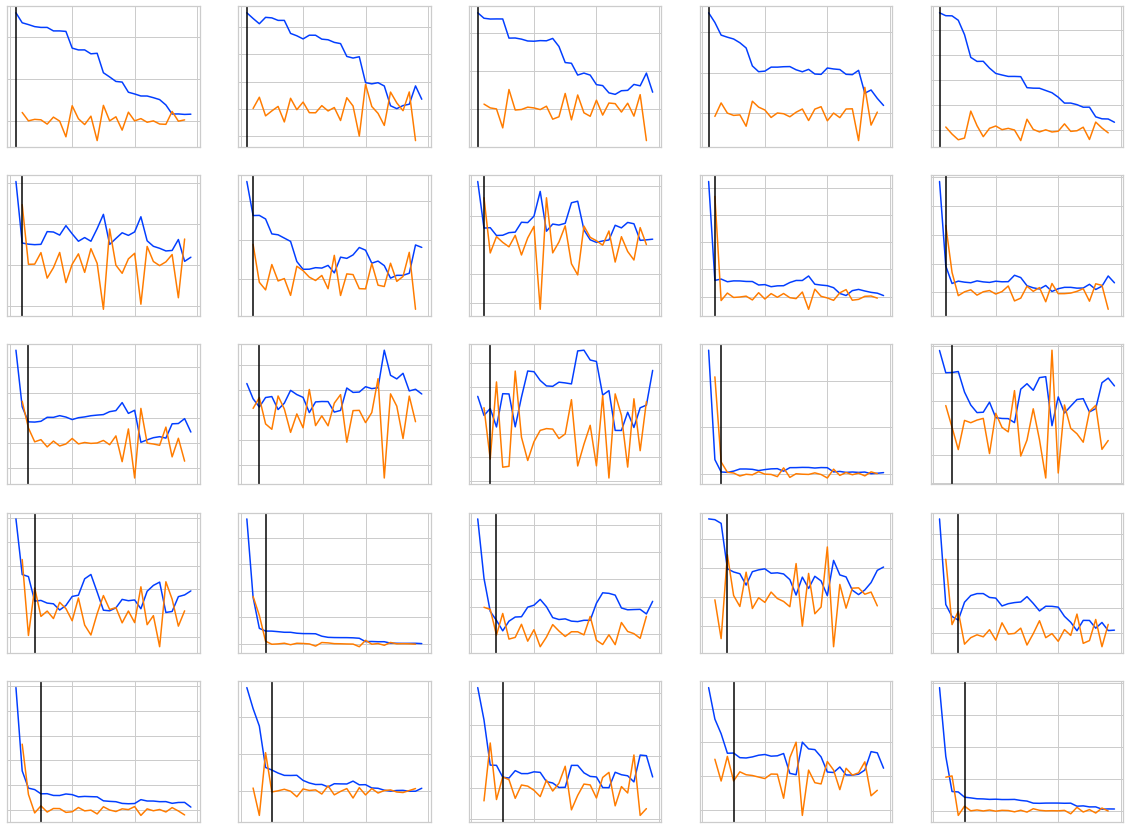

In [8]:
intervention = 30

fig, ax = plt.subplots(5,5, figsize = (20, 15))

for plotx in range(5):
    for ploty in range(5):
        example_df = tdf[plotx][ploty]
        
        uncorrolated_sv = {}

        correlation_val = []
        
        for i in range(1,30):
            m = syn_model(0, i, [example_df], 200, intervention, otherStates=list(example_df.columns)[1:])
            m.fit_model(force_positive=False)
            error = (m.denoisedDF[m.state].values - m.train[m.state].values)
            error = (error - error.mean()) / error.std()
            corr, _ = pearsonr(error, m.train[m.state].values) #pearsonr # spearmanr

            if abs(corr) < .25 and m.state not in uncorrolated_sv:
                uncorrolated_sv[m.state] = i

            # print(p_value)
            # if p_value > p_thresh:

            correlation_val.append((i,corr))


        sv = [x[0] for x in correlation_val]
        corr = [abs(x[1]) for x in correlation_val]
        ax[plotx][ploty].plot(sv, corr, '-')
        ax[plotx][ploty].plot(*diff2(sv, corr), '-')
        ax[plotx][ploty].axvline(plotx + 1, color='black')
        ax[plotx][ploty].set_xticklabels([])
        ax[plotx][ploty].set_yticklabels([])

plt.show()

